# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline
# Add-on : Set plotting options
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)
# Add-on : Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")
# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



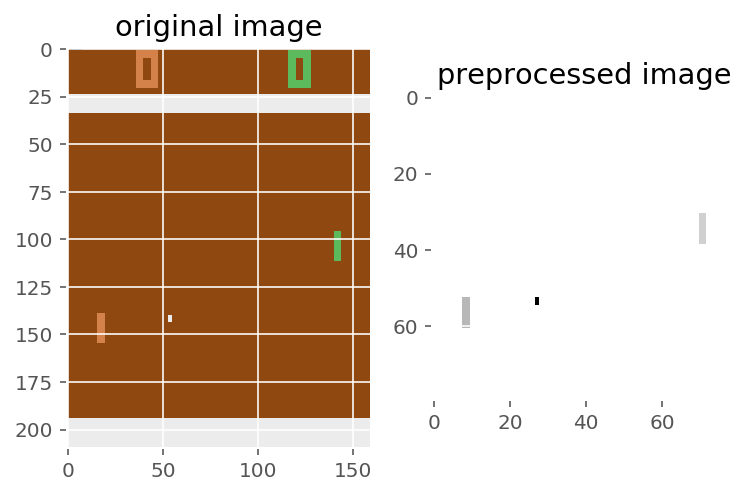

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4)
        self.size=1*20*20
        
        # 1 fully connected layer
        self.fc = nn.Linear(self.size, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        return self.sig(self.fc(x))


# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


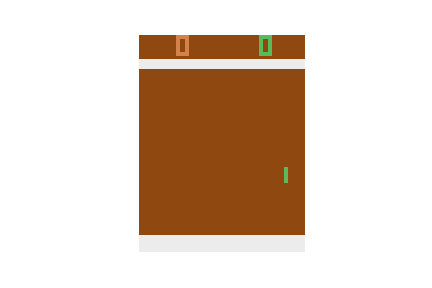
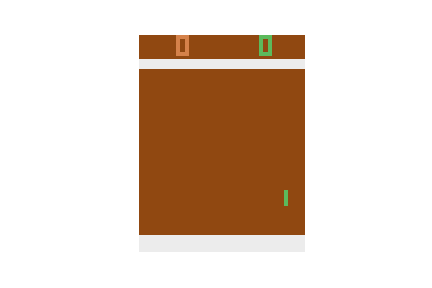
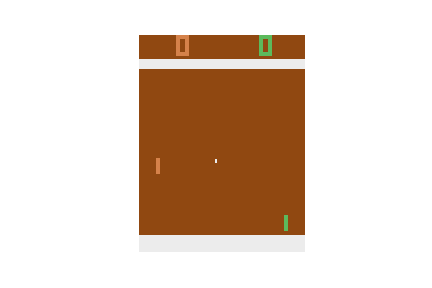
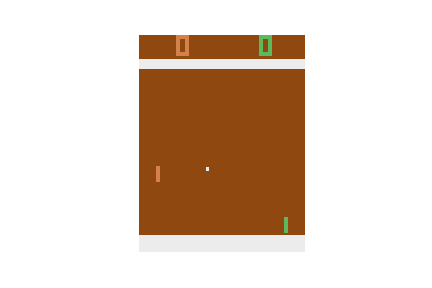
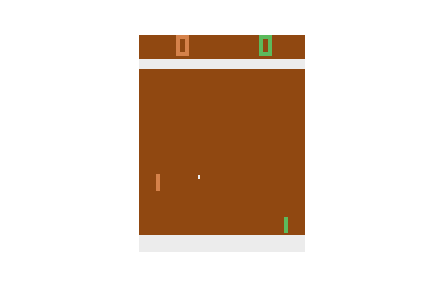
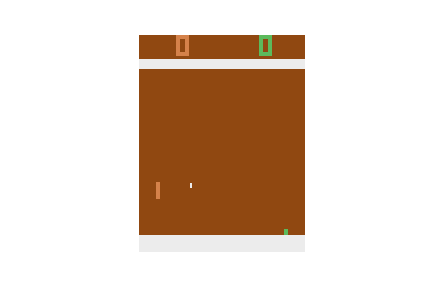
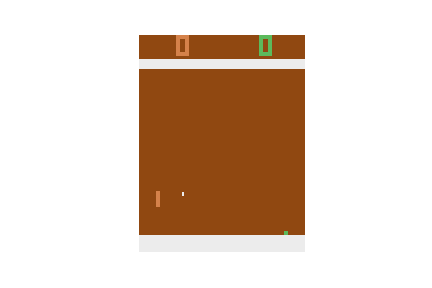
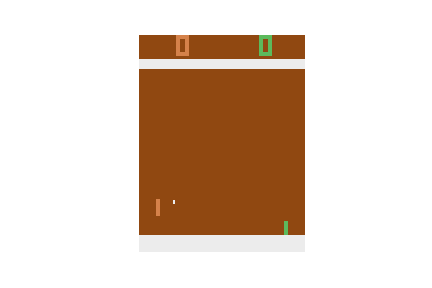
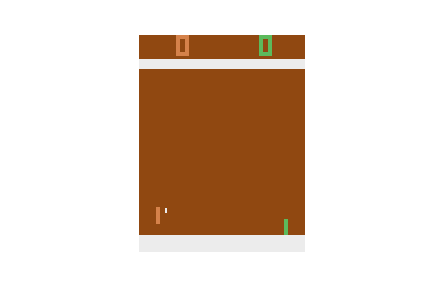
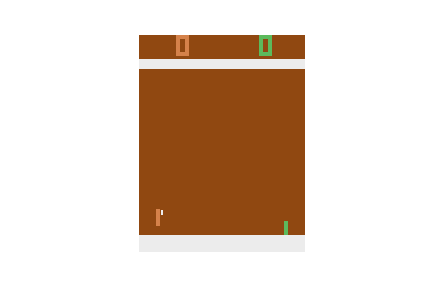
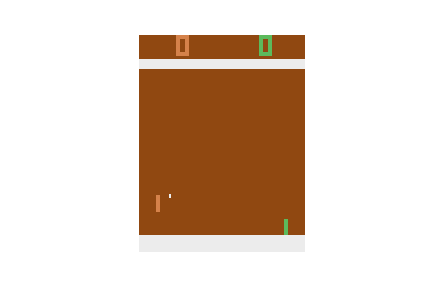
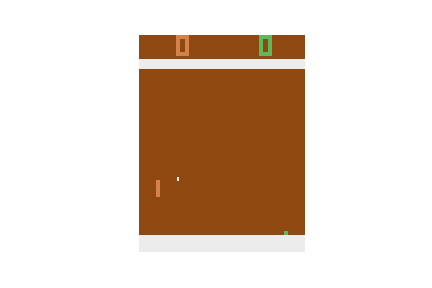
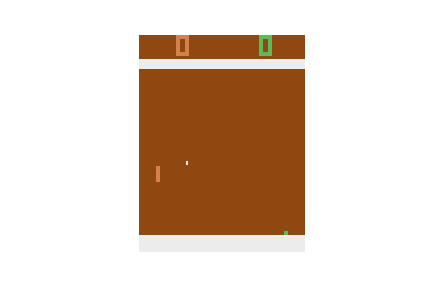
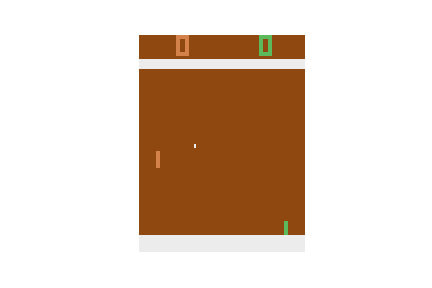
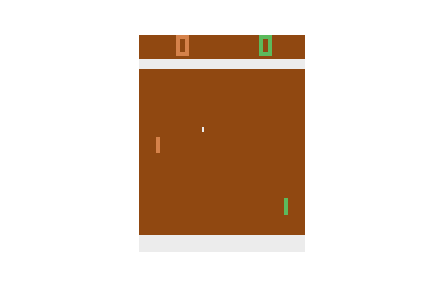
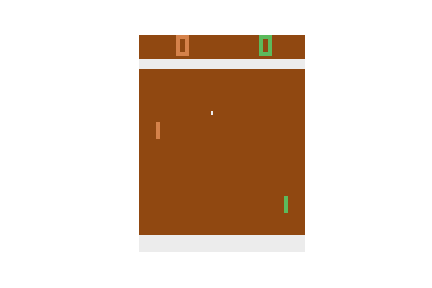
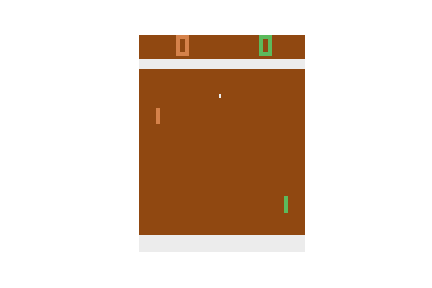
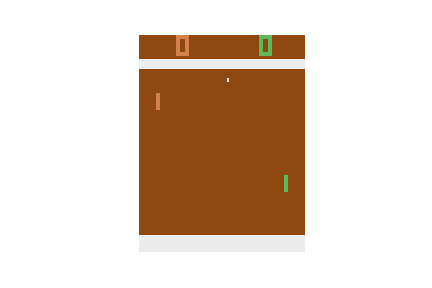
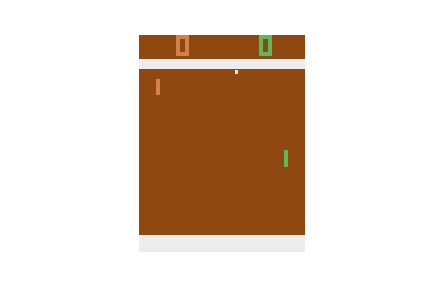
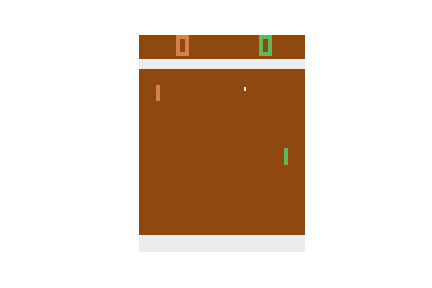
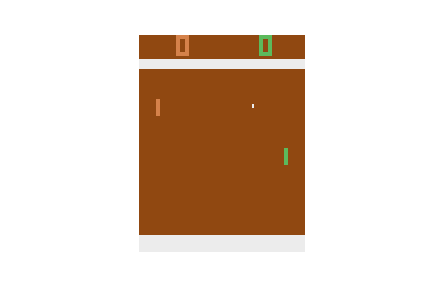
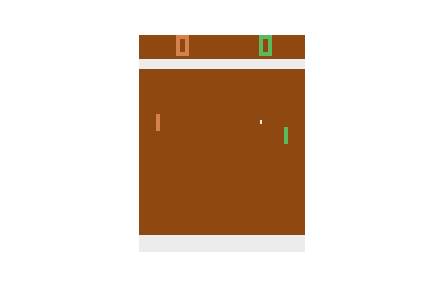
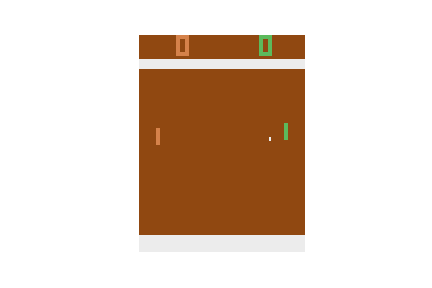
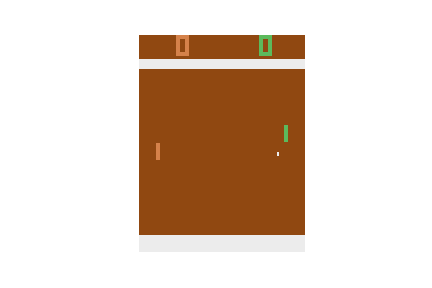
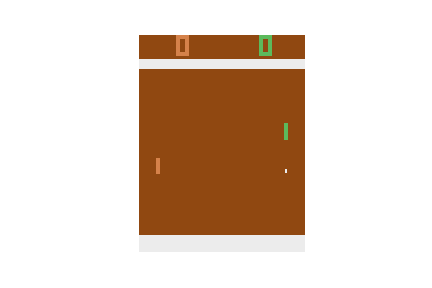
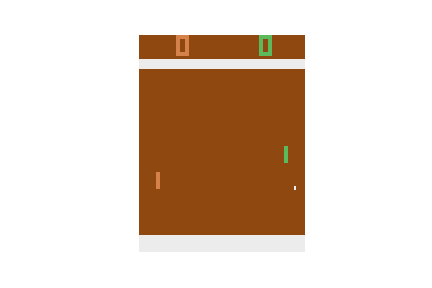
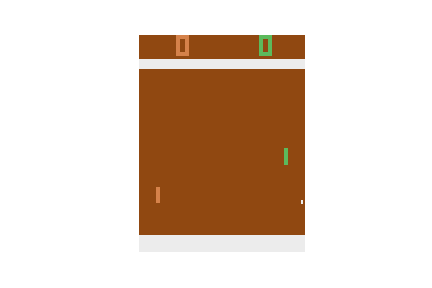
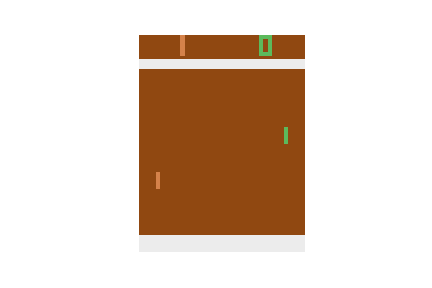
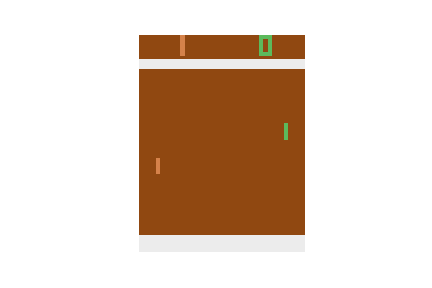
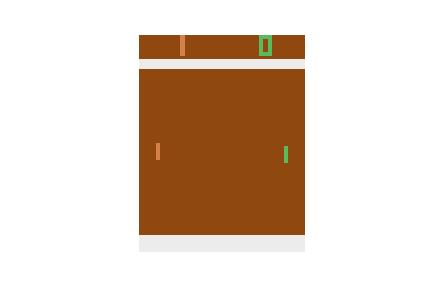
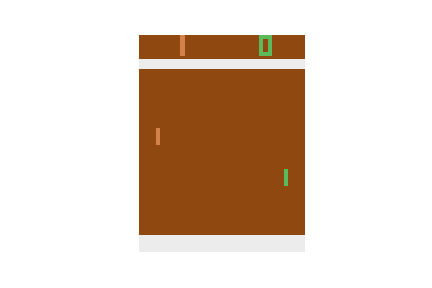
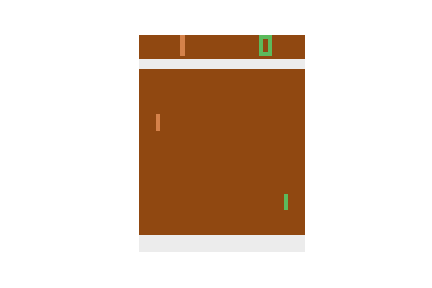
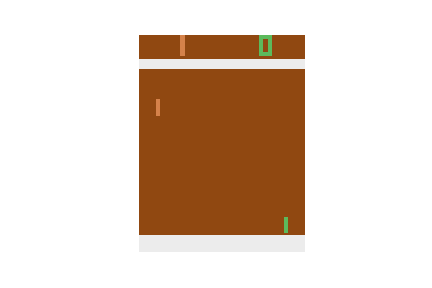
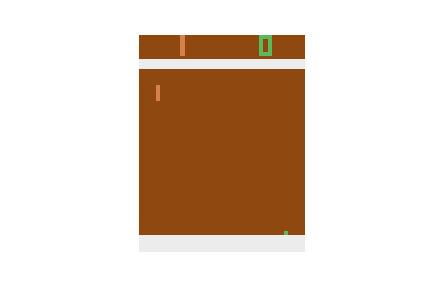
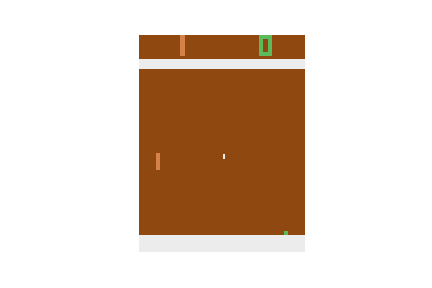
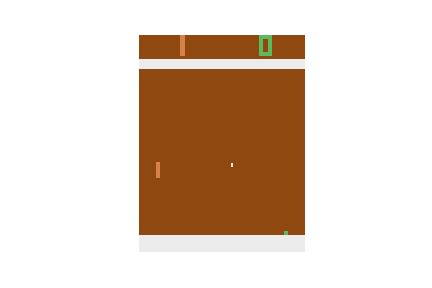
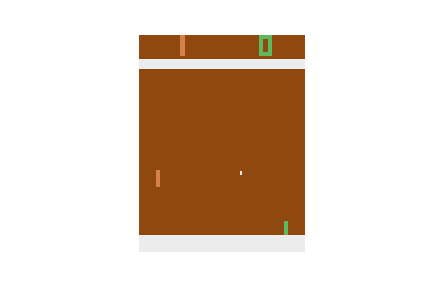
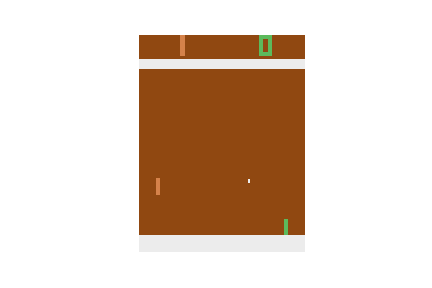
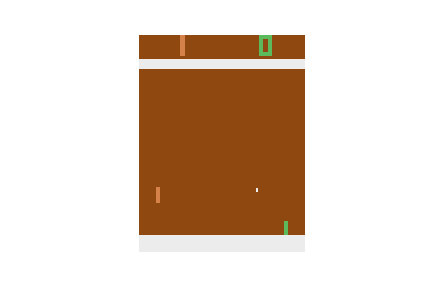
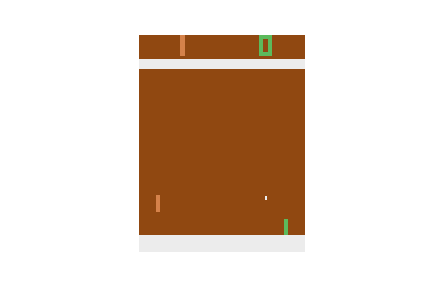
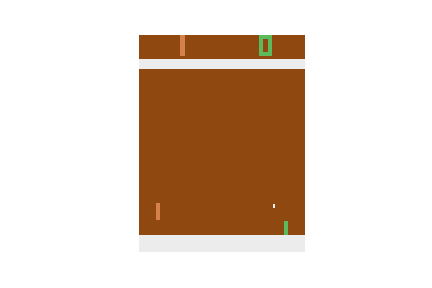
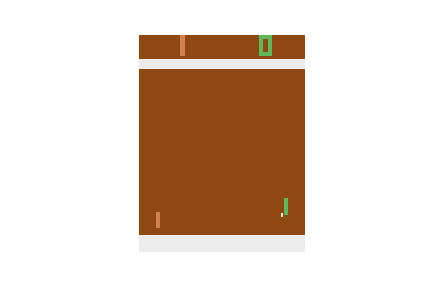
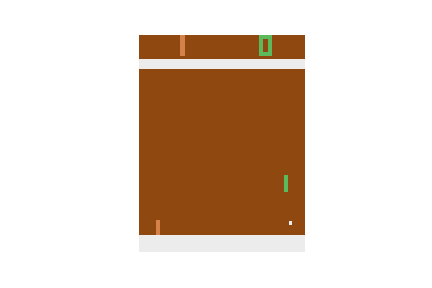
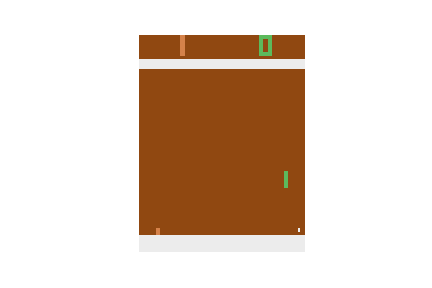
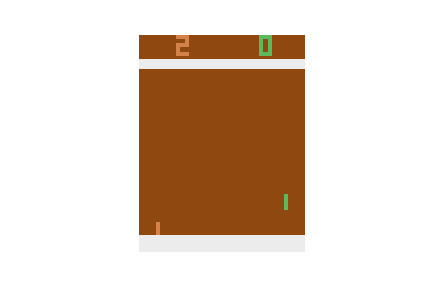
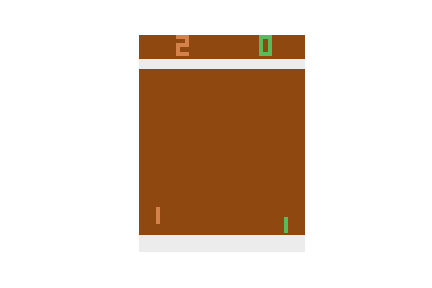
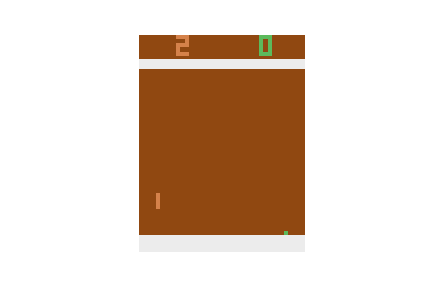
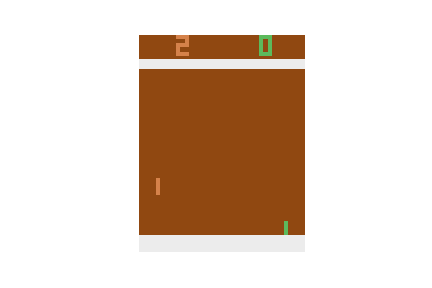
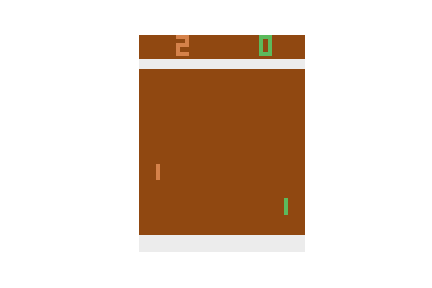
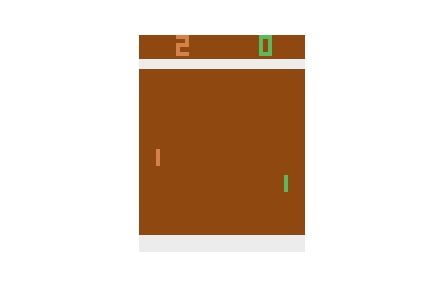
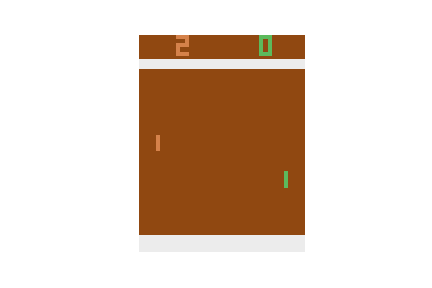
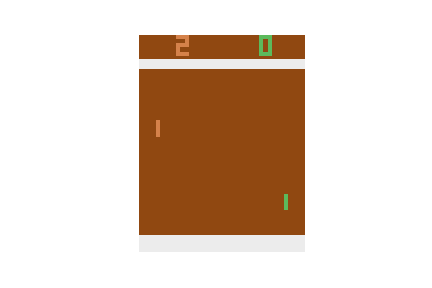
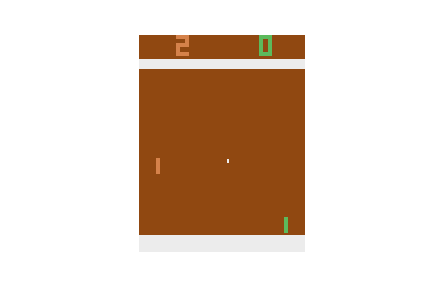
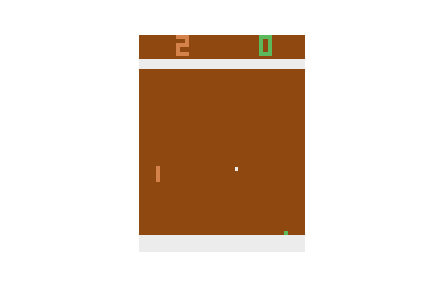
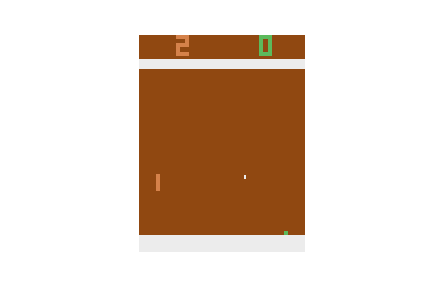
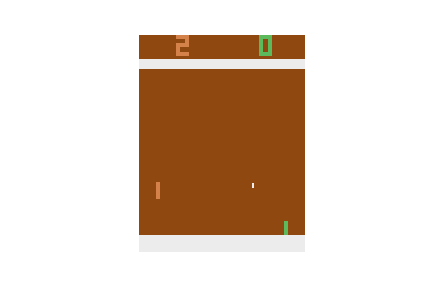
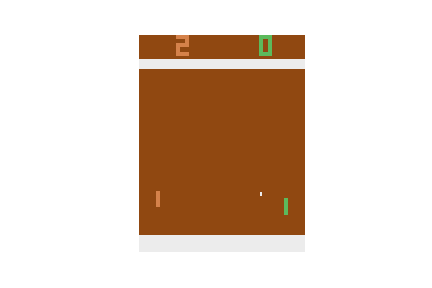
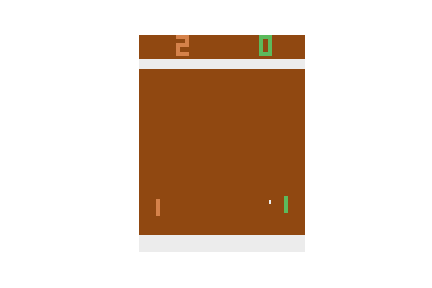
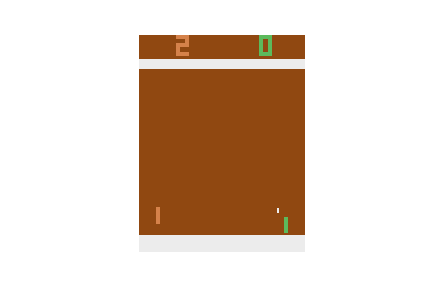
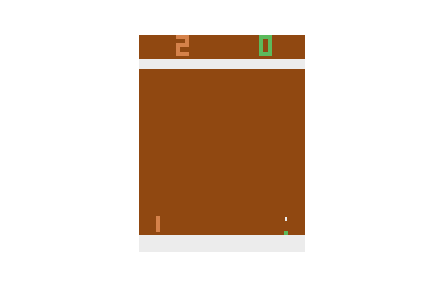
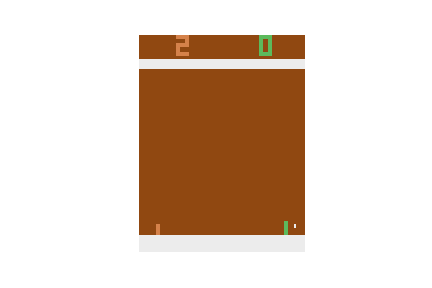
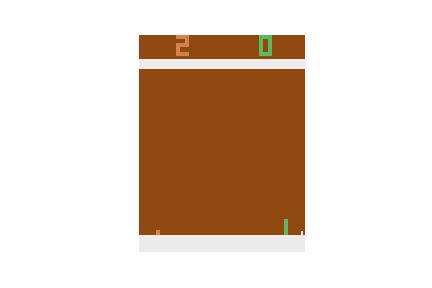
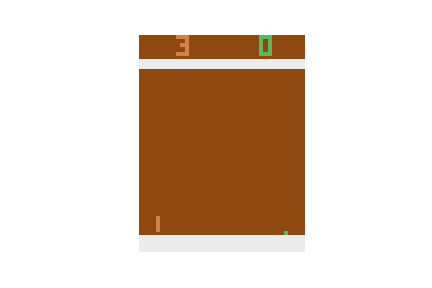
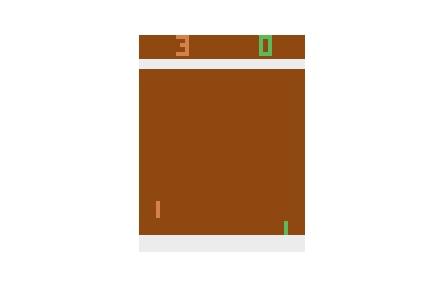
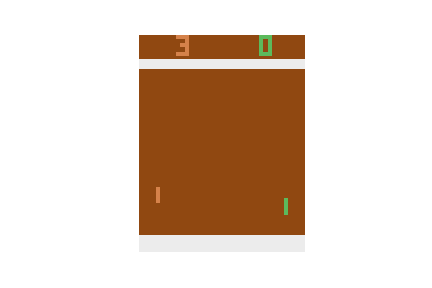
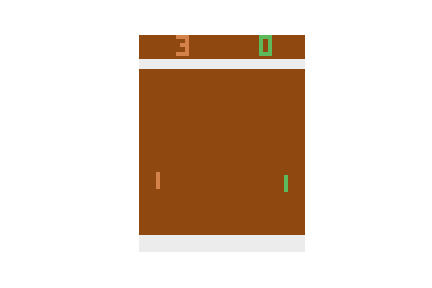
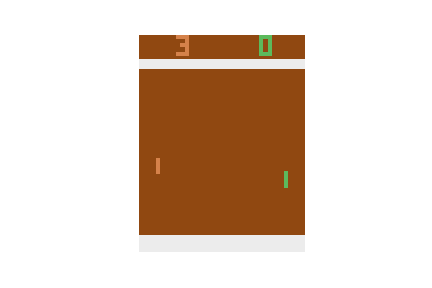
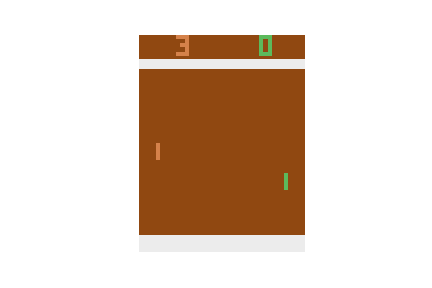
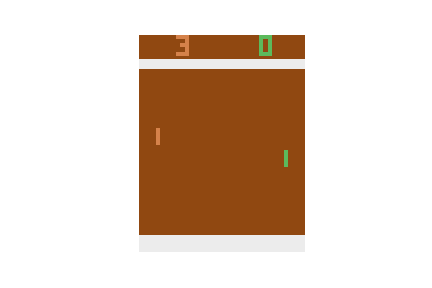
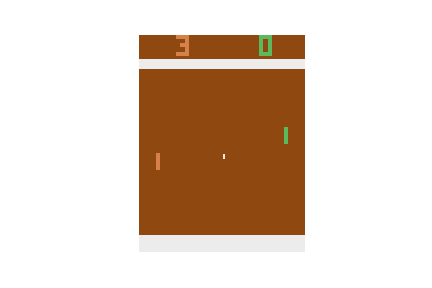
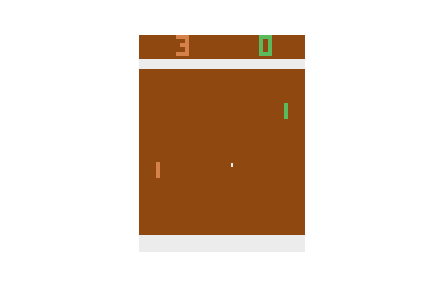
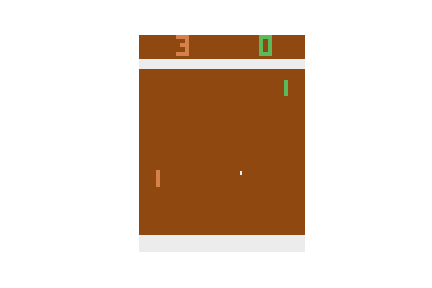
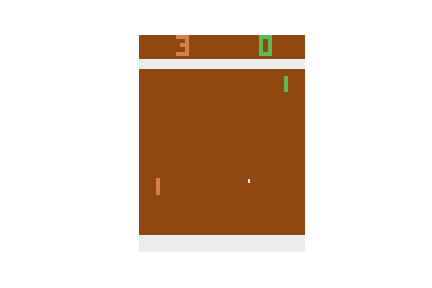
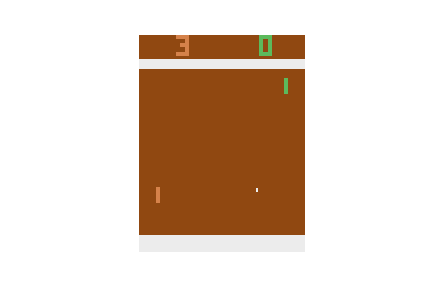
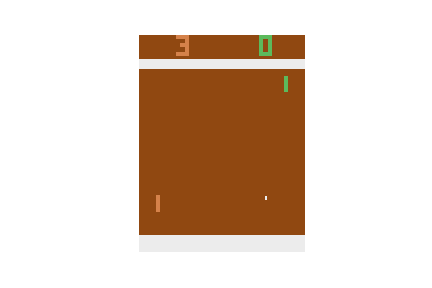
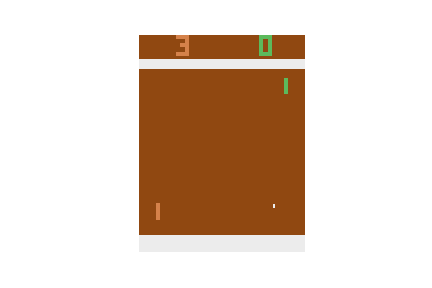
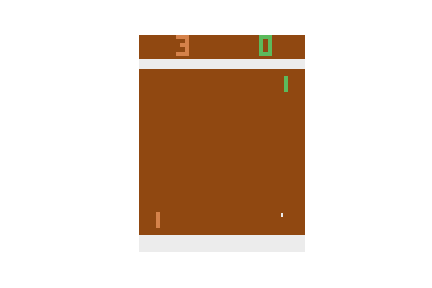
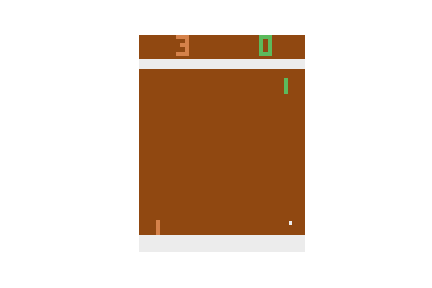
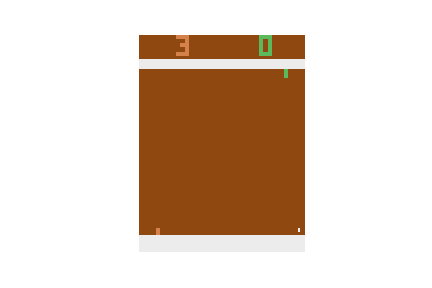
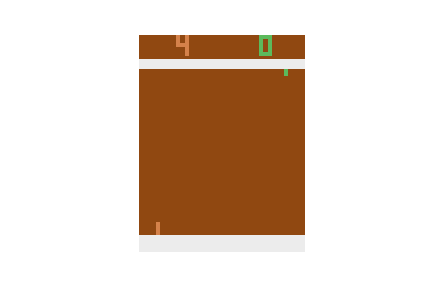
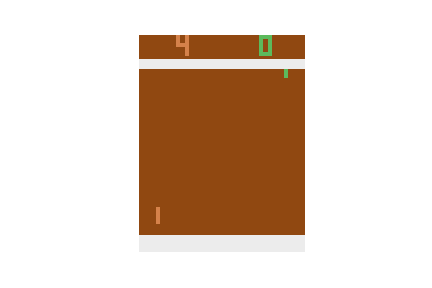
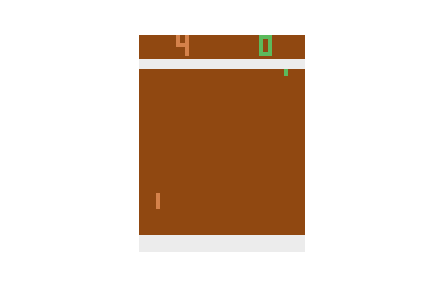
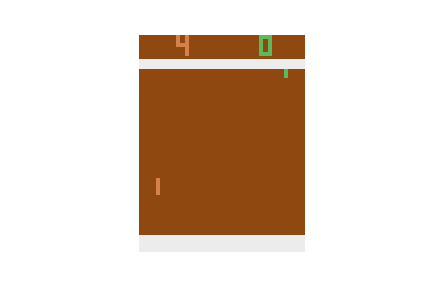
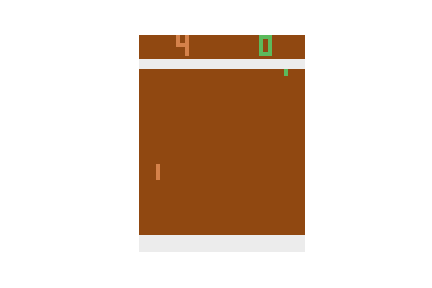
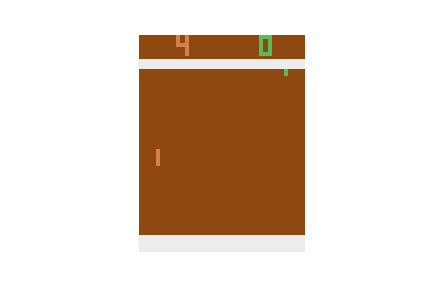
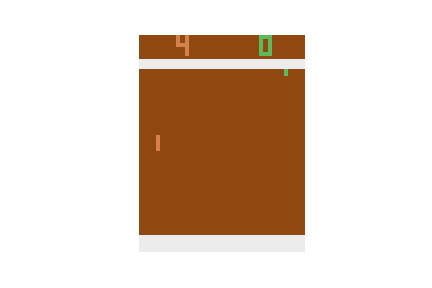
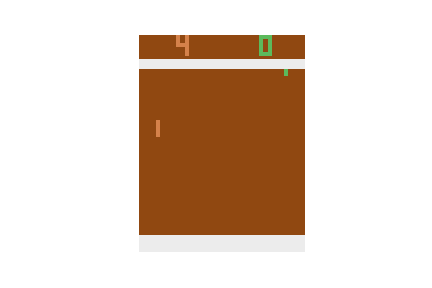
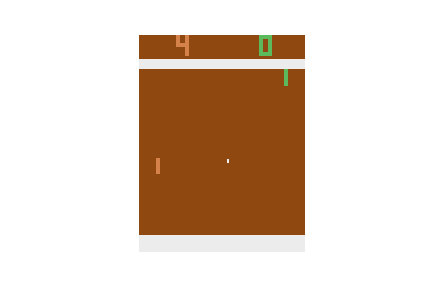
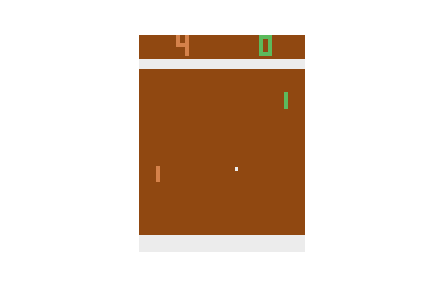
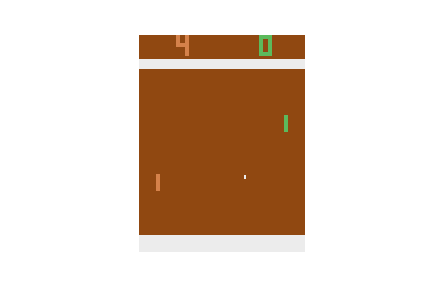
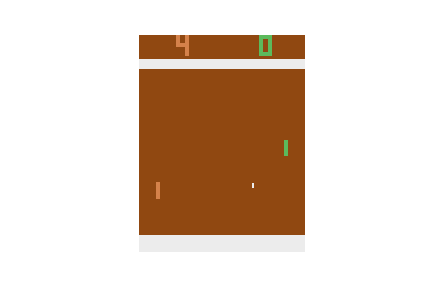
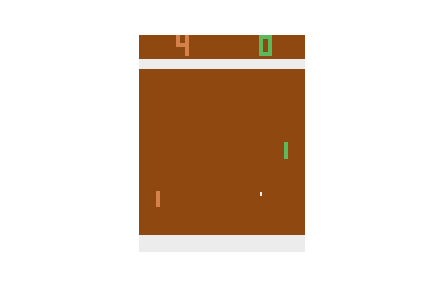
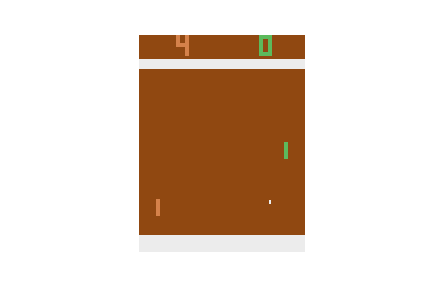
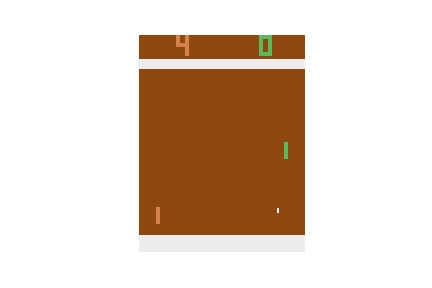
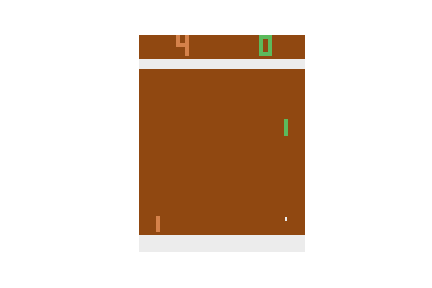
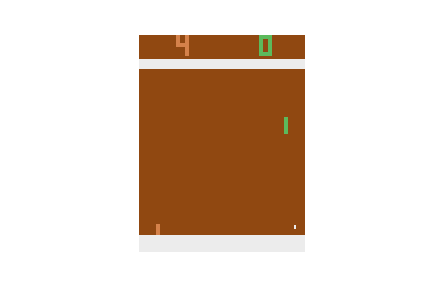
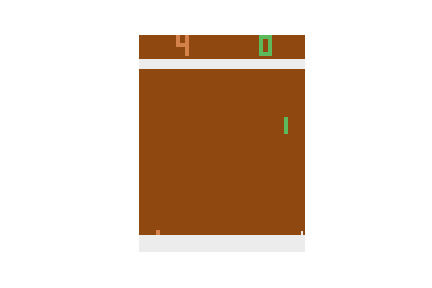
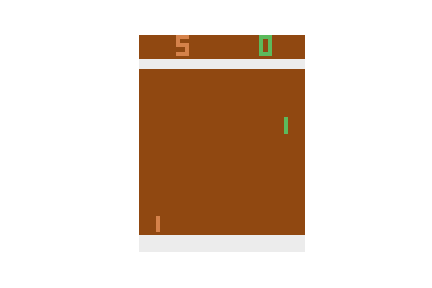
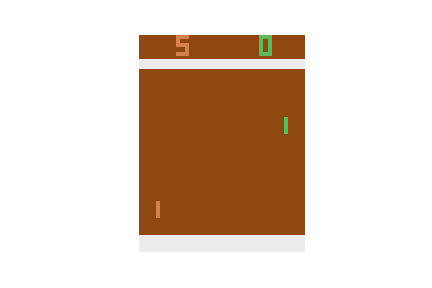
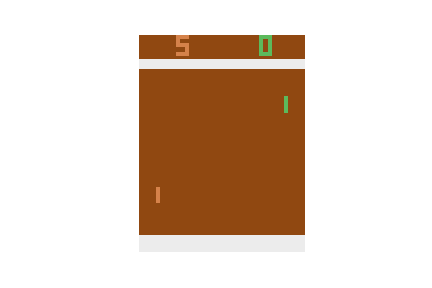
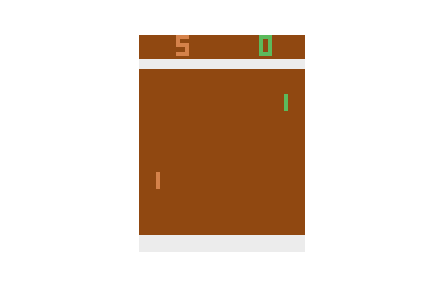
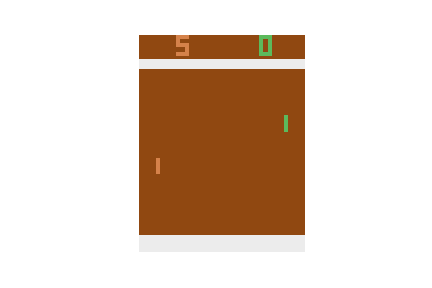
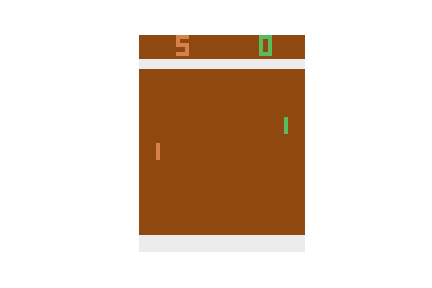
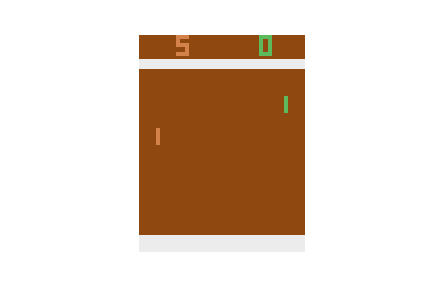
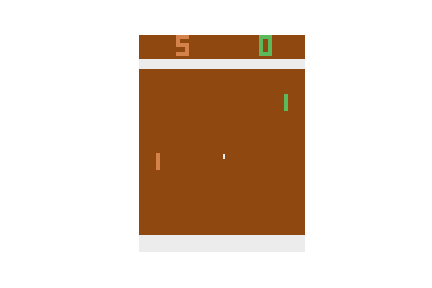
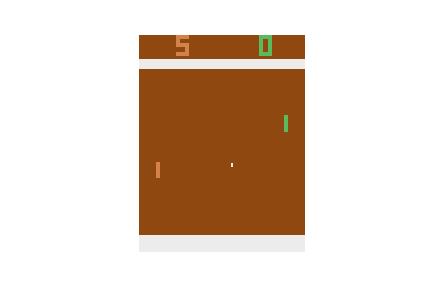
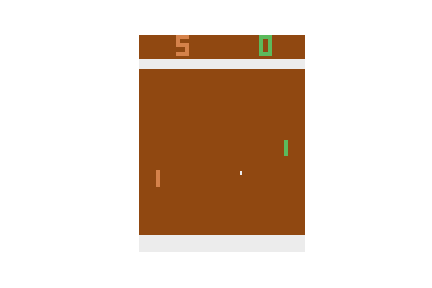
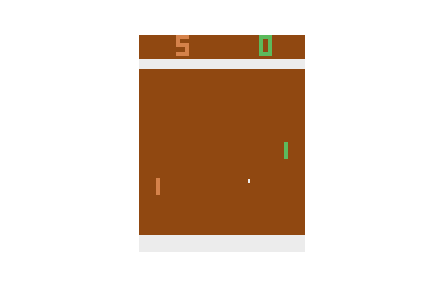
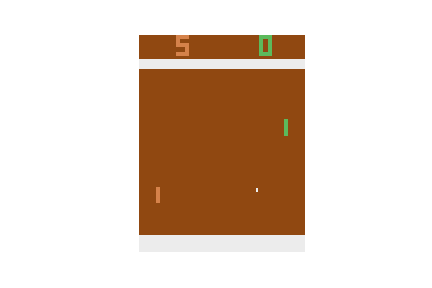
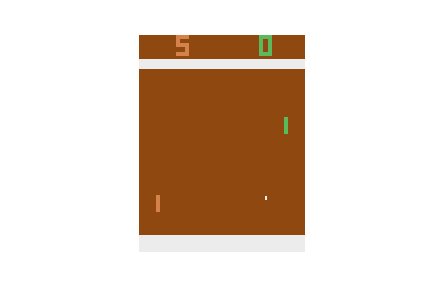
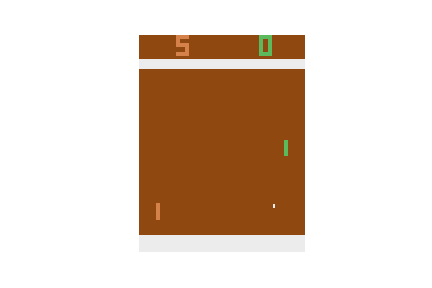
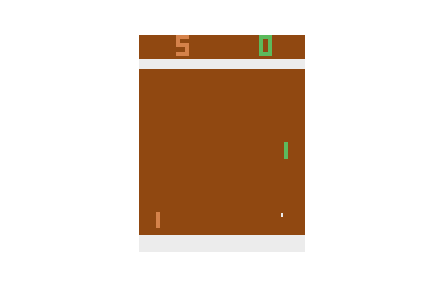
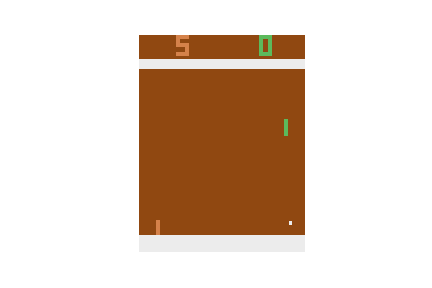
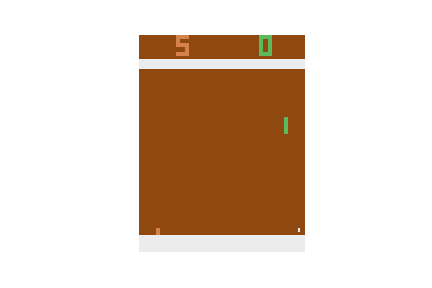
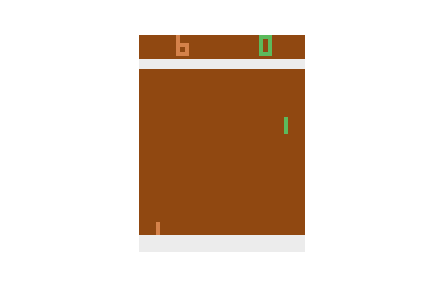
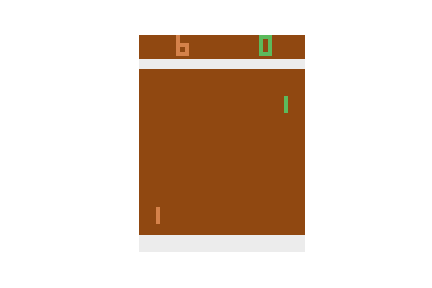
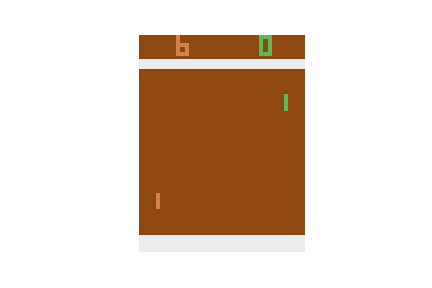
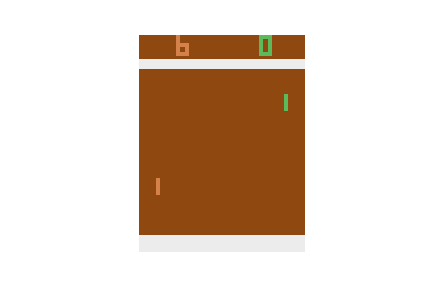
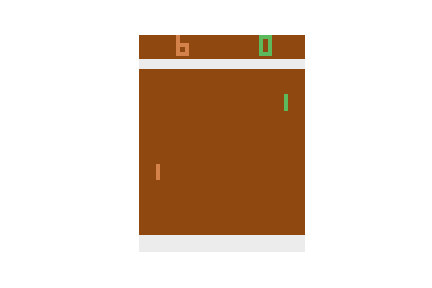
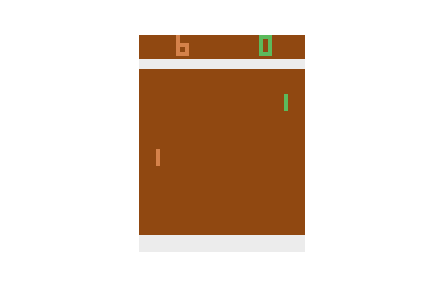
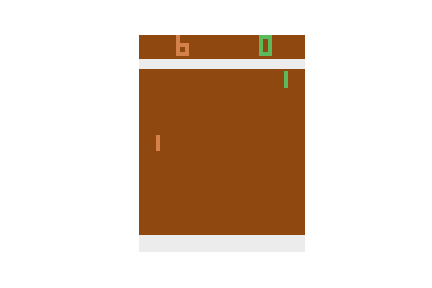
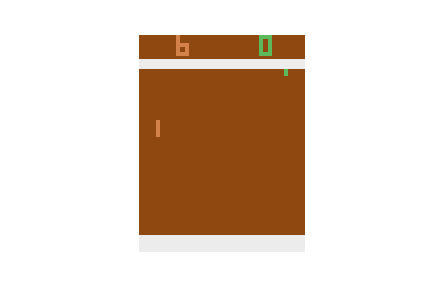
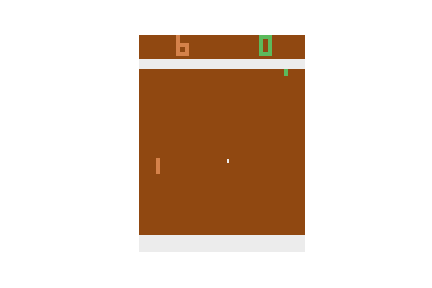
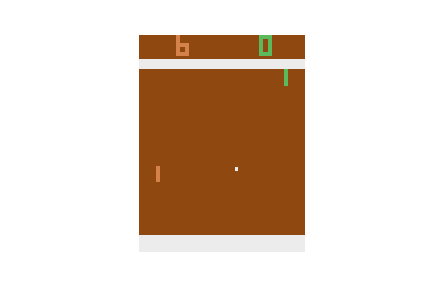
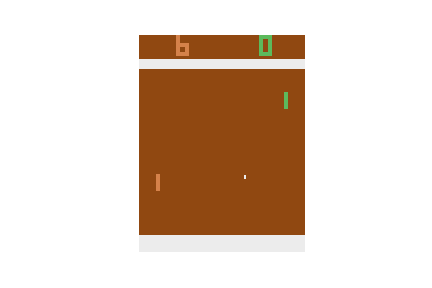
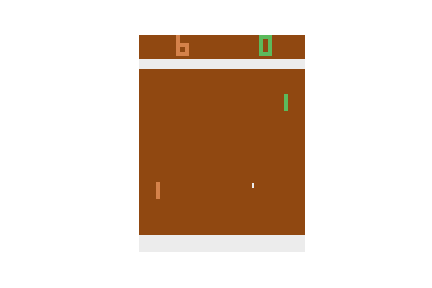
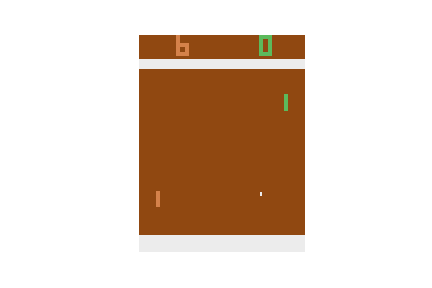
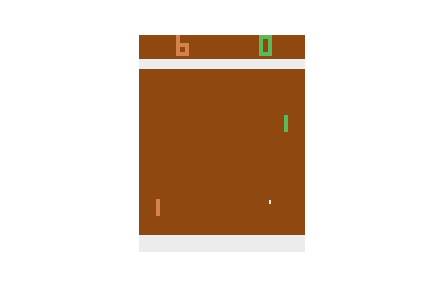
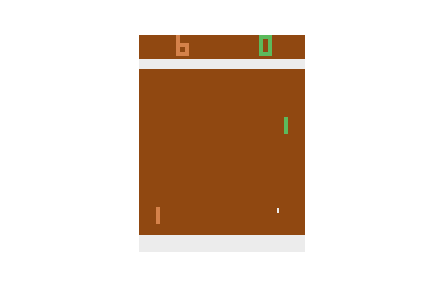
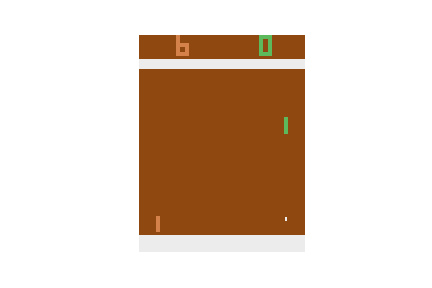
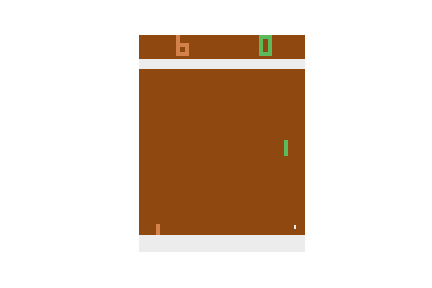
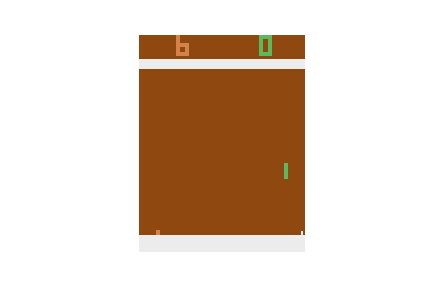
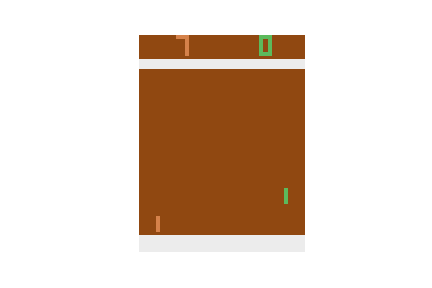
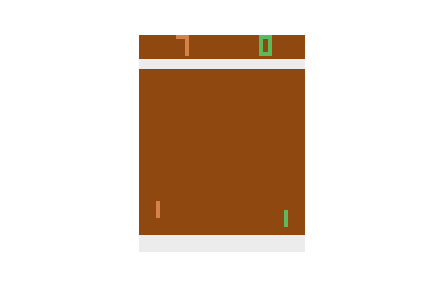
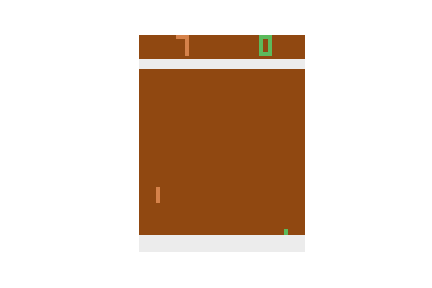
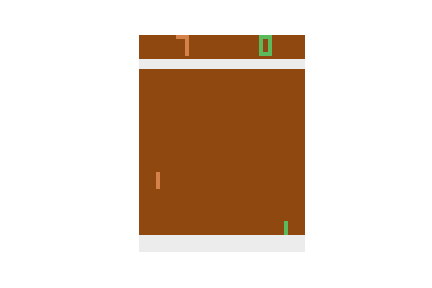
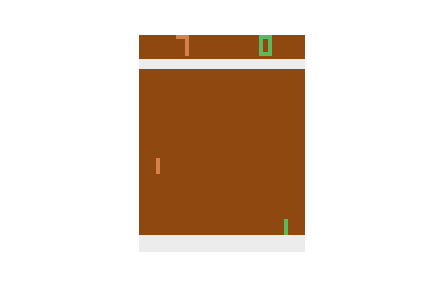
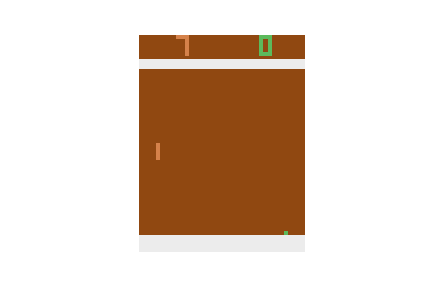
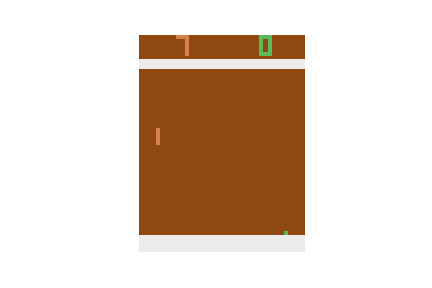
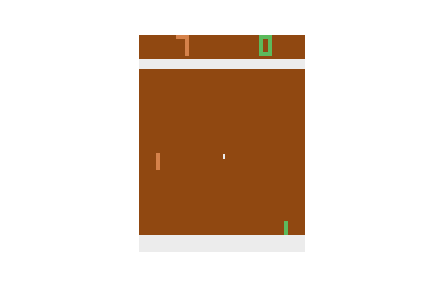
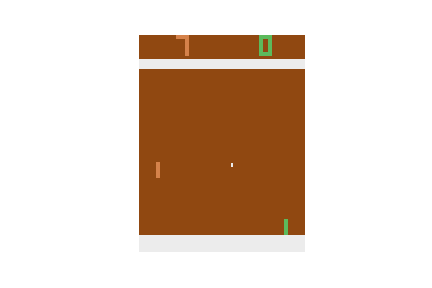
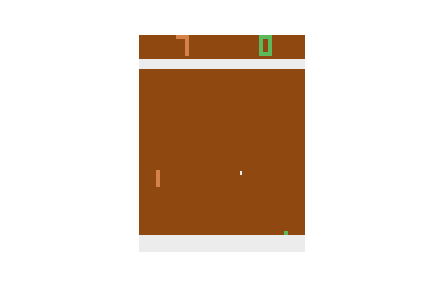
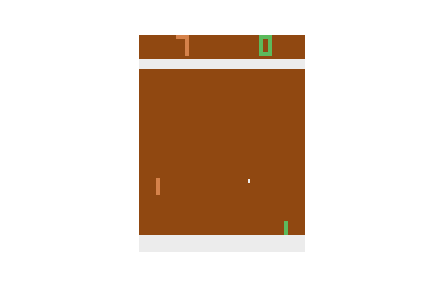
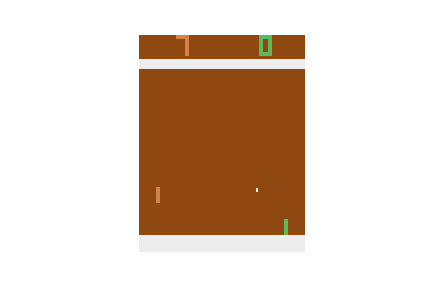
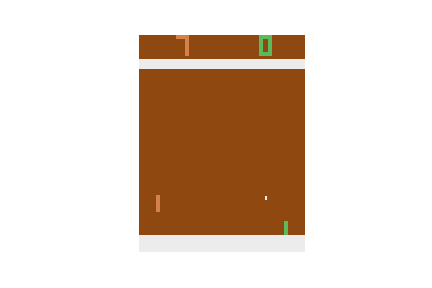
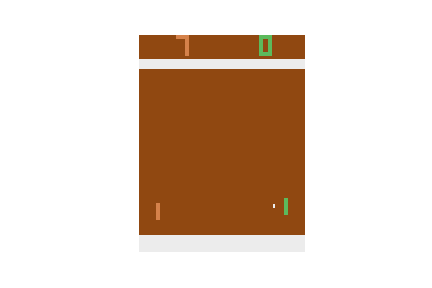
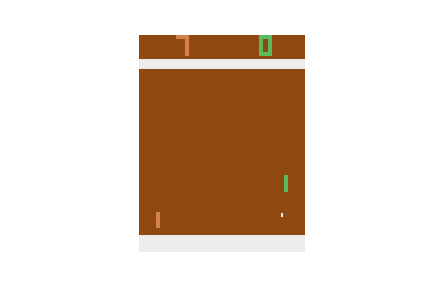
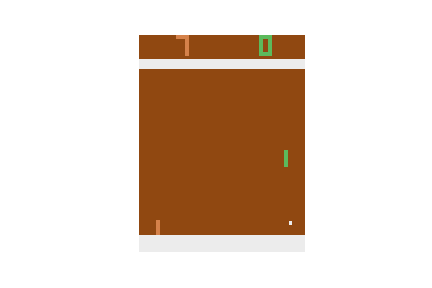
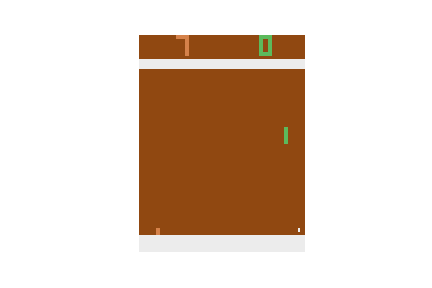
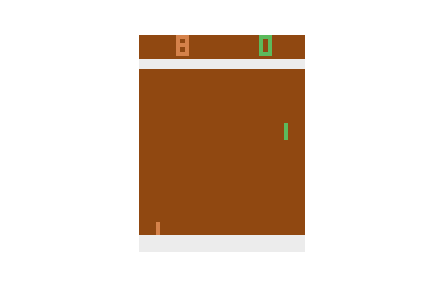
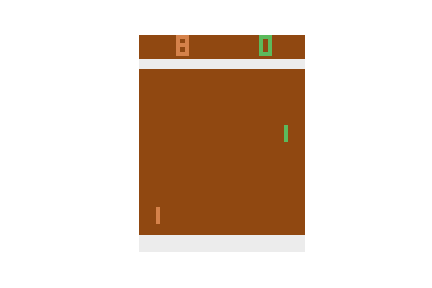
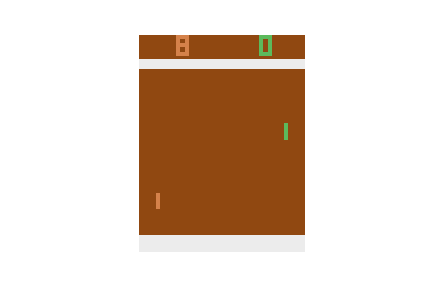
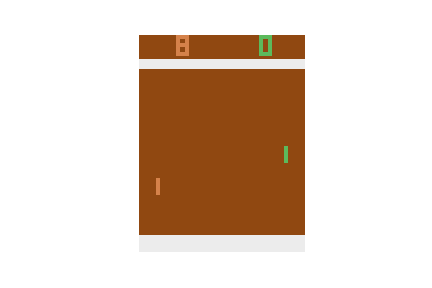
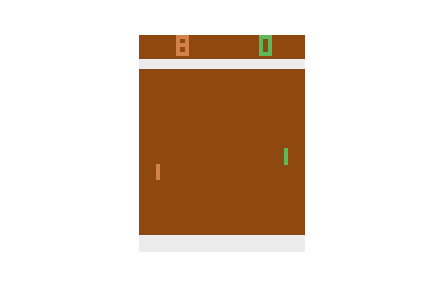
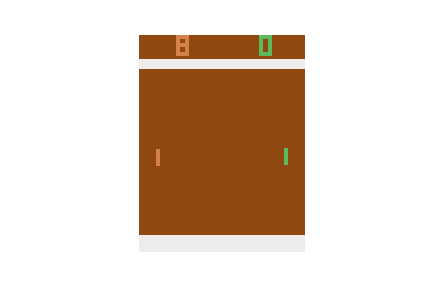
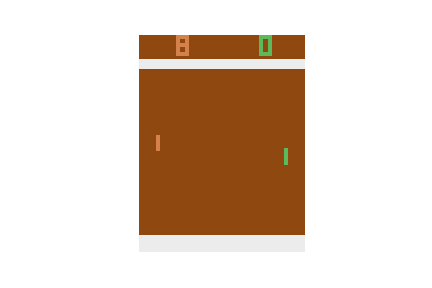
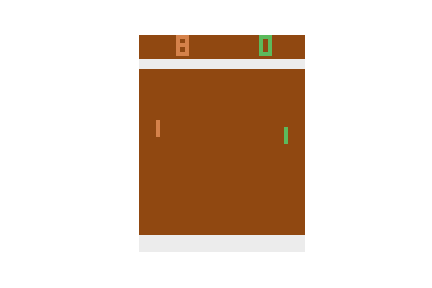
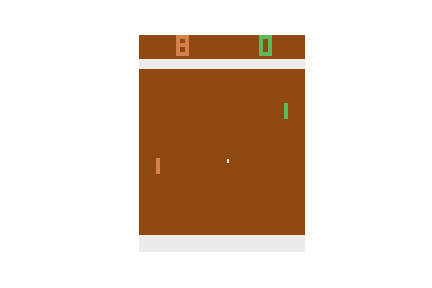
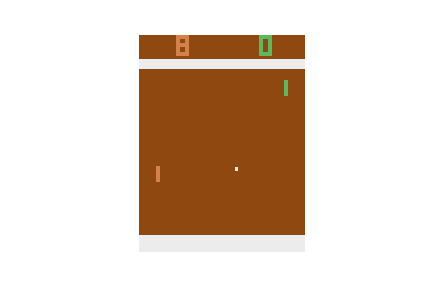
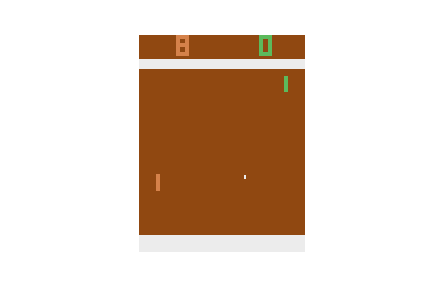
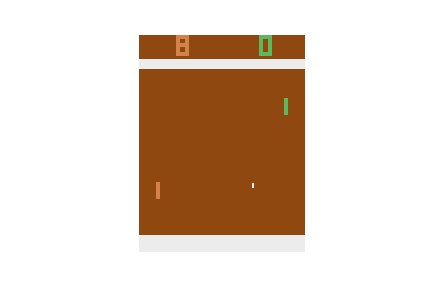
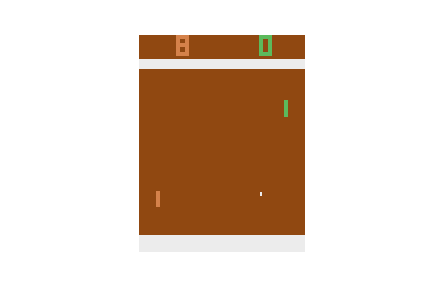
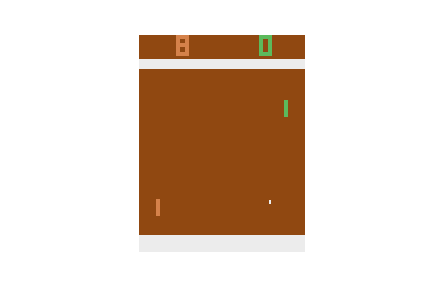
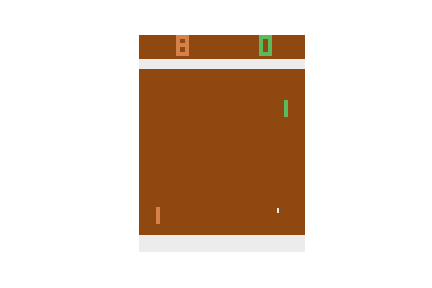
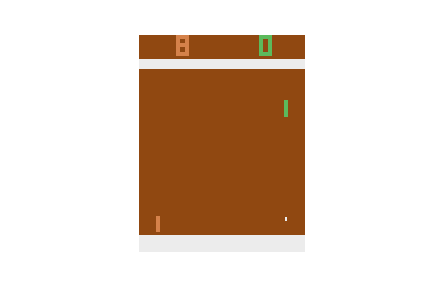
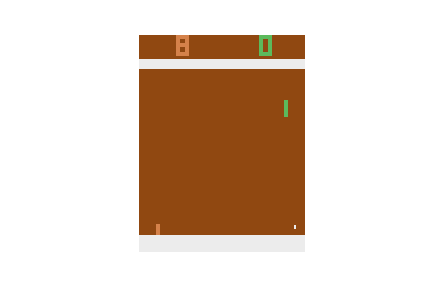
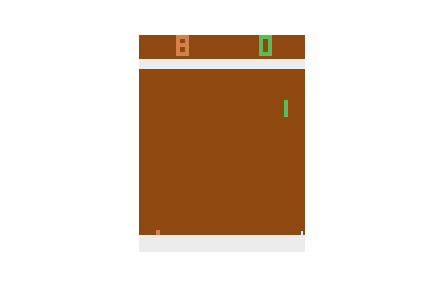
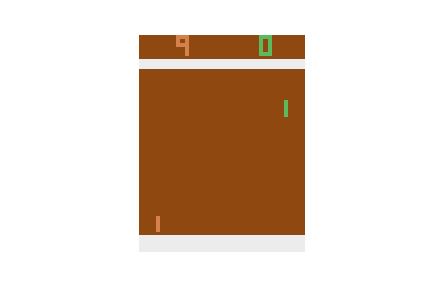
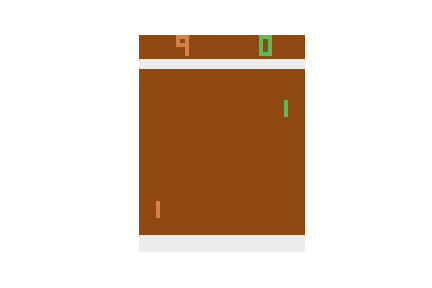
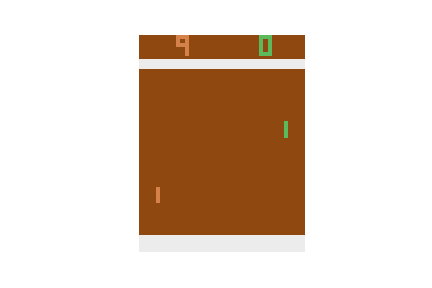
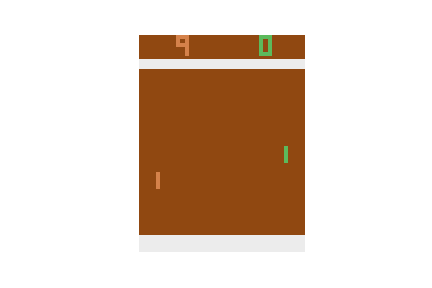
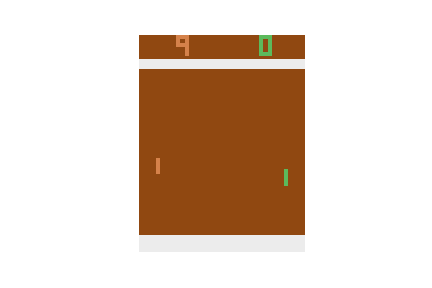
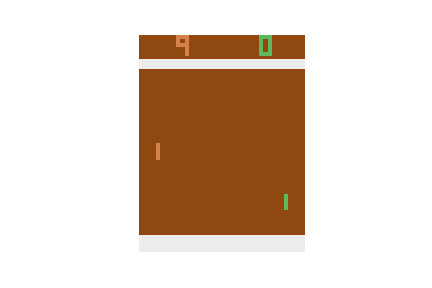
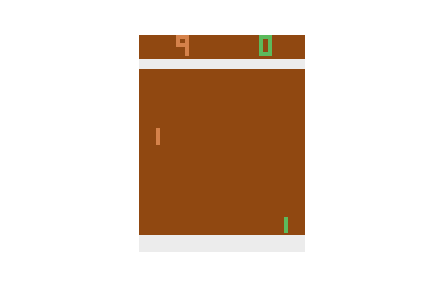
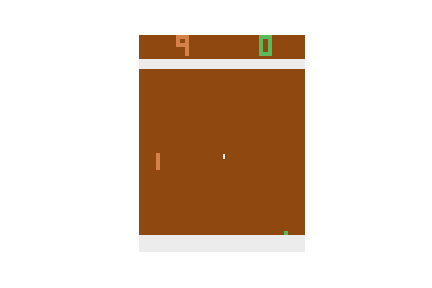
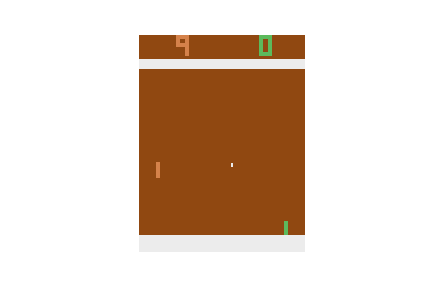
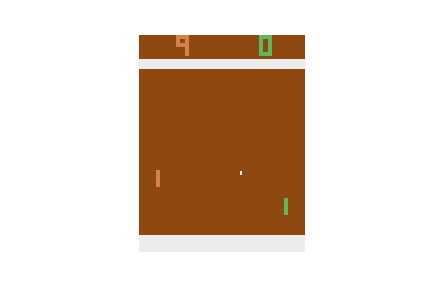
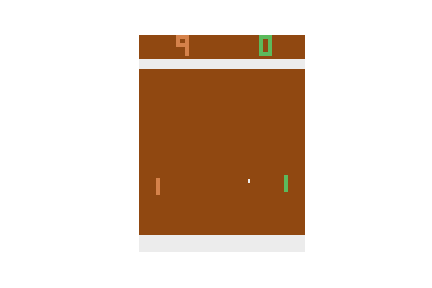
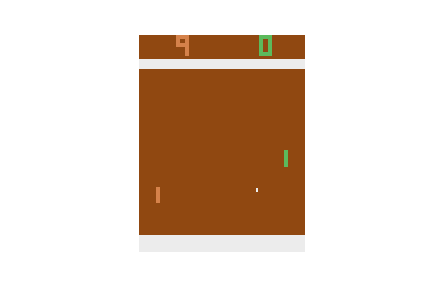
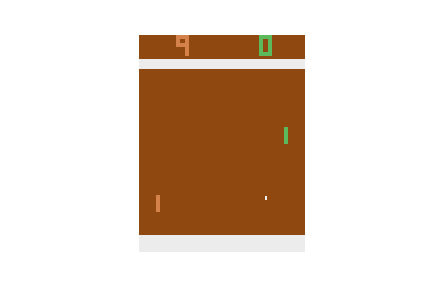
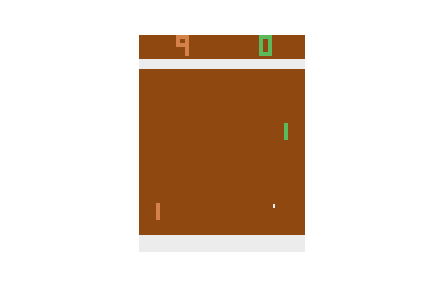
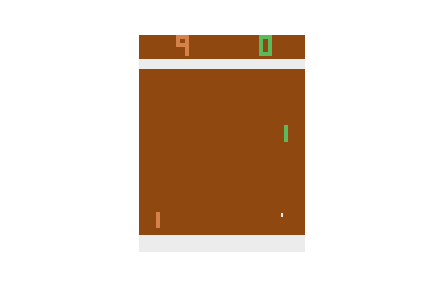
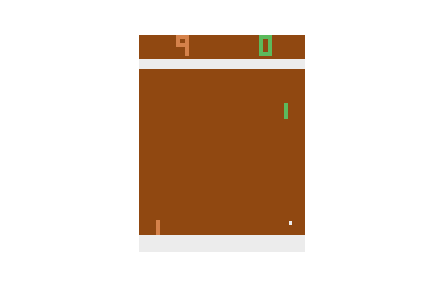
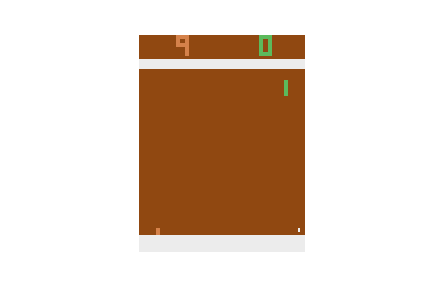
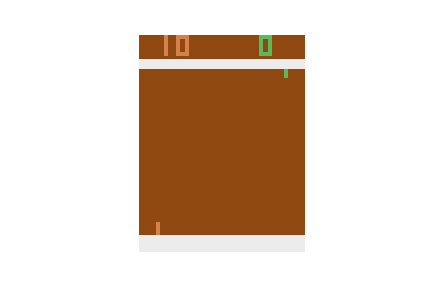
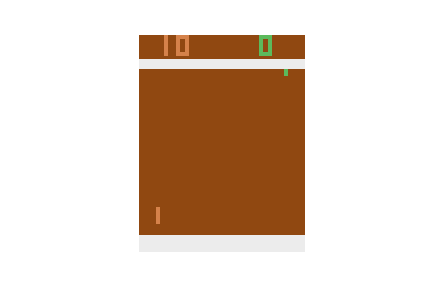
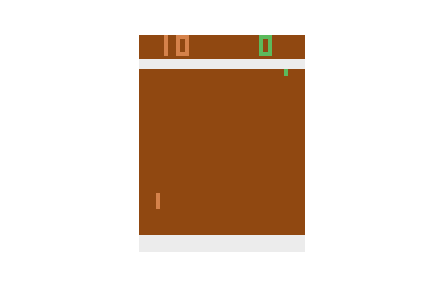
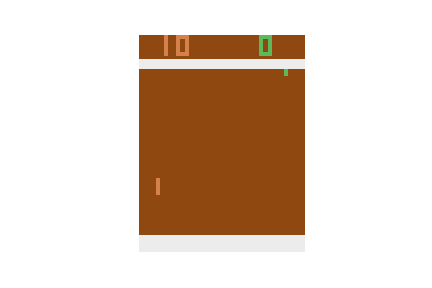
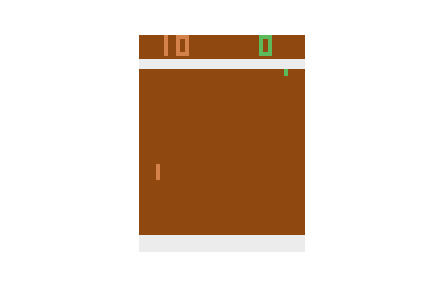
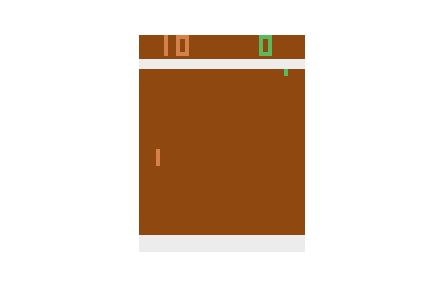
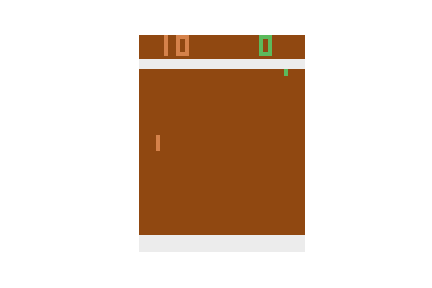
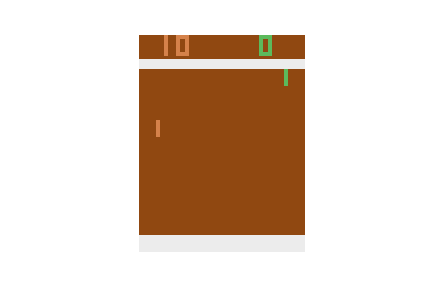
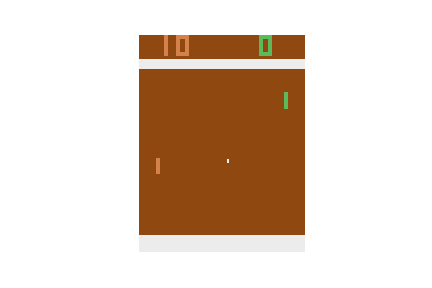
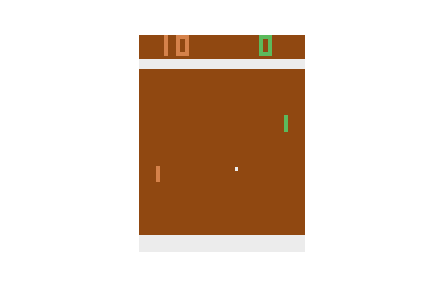
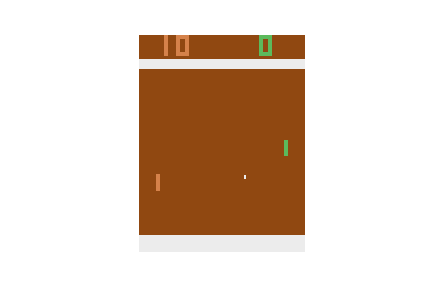
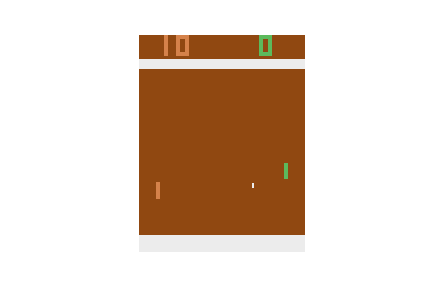
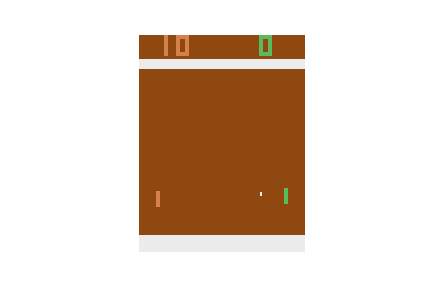
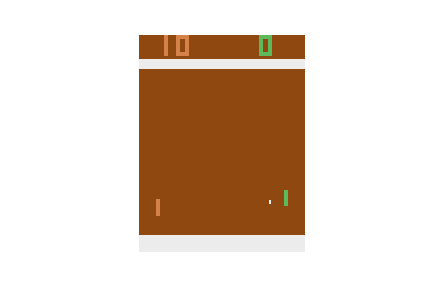
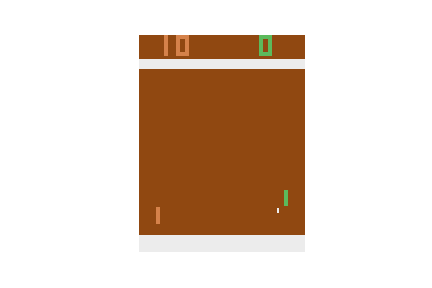
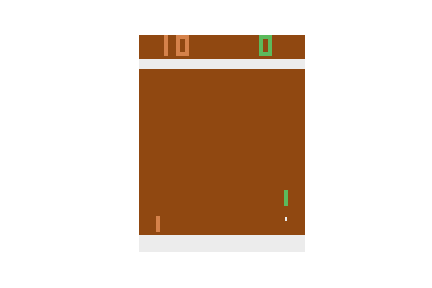

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [ ]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [6]:
# Install Progressbar
!pip install progressbar2
!conda install -y tqdm==4.11.2

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Solving environment: done

# All requested packages already installed.



In [7]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

training loop:   4% |#                                         | ETA:   0:28:01

Episode: 20, score: -14.125000
[-13. -14. -15. -13. -16. -14. -12. -16.]


training loop:   8% |###                                       | ETA:   0:26:21

Episode: 40, score: -13.250000
[-12. -16. -11. -14.  -9. -15. -16. -13.]


training loop:  12% |#####                                     | ETA:   0:25:01

Episode: 60, score: -15.625000
[-16. -16. -16. -13. -16. -16. -16. -16.]


training loop:  16% |######                                    | ETA:   0:23:48

Episode: 80, score: -12.375000
[-12. -16. -10. -10. -13.  -9. -16. -13.]


training loop:  20% |########                                  | ETA:   0:22:37

Episode: 100, score: -13.375000
[-16. -15.  -9. -14. -13.  -9. -16. -15.]


training loop:  24% |##########                                | ETA:   0:21:27

Episode: 120, score: -11.625000
[-13. -10. -12.  -7. -14. -14. -13. -10.]


training loop:  28% |###########                               | ETA:   0:20:18

Episode: 140, score: -13.875000
[-15. -14. -16. -13. -14. -12. -10. -17.]


training loop:  32% |#############                             | ETA:   0:19:09

Episode: 160, score: -11.250000
[ -8. -12. -10. -11. -12. -13. -10. -14.]


training loop:  36% |###############                           | ETA:   0:18:01

Episode: 180, score: -11.875000
[ -8. -13. -11. -13. -16. -10. -13. -11.]


training loop:  40% |################                          | ETA:   0:16:53

Episode: 200, score: -10.500000
[ -7. -13. -11. -16.  -9.  -8.  -9. -11.]


training loop:  44% |##################                        | ETA:   0:15:45

Episode: 220, score: -8.000000
[ -6.  -8.  -6.  -8.  -8. -10. -10.  -8.]


training loop:  48% |####################                      | ETA:   0:14:37

Episode: 240, score: -6.125000
[ -6.  -4.  -5.  -7. -10.  -9.  -2.  -6.]


training loop:  52% |#####################                     | ETA:   0:13:29

Episode: 260, score: -5.250000
[-8. -6. -3. -6. -2. -8. -5. -4.]


training loop:  56% |#######################                   | ETA:   0:12:22

Episode: 280, score: -3.000000
[-2. -8.  0. -4. -1. -1. -1. -7.]


training loop:  60% |#########################                 | ETA:   0:11:14

Episode: 300, score: -3.250000
[ -1.  -6.  -3. -10.  -1.  -1.  -3.  -1.]


training loop:  64% |##########################                | ETA:   0:10:07

Episode: 320, score: -1.125000
[-1. -2. -1. -1. -1. -2. -1.  0.]


training loop:  68% |############################              | ETA:   0:08:59

Episode: 340, score: -0.750000
[-1. -1.  0. -1. -1. -1. -1.  0.]


training loop:  72% |##############################            | ETA:   0:07:52

Episode: 360, score: -1.250000
[-1. -1. -1. -1. -2. -2. -1. -1.]


training loop:  76% |###############################           | ETA:   0:06:44

Episode: 380, score: -0.500000
[ 0.  0. -1.  0. -1. -1.  0. -1.]


training loop:  80% |#################################         | ETA:   0:05:37

Episode: 400, score: 1.250000
[ 2.  2.  3.  0.  2.  2. -1.  0.]


training loop:  84% |###################################       | ETA:   0:04:29

Episode: 420, score: 0.750000
[ 0.  1. -2.  2.  2.  3.  2. -2.]


training loop:  88% |####################################      | ETA:   0:03:22

Episode: 440, score: 1.875000
[-2.  5.  1.  3.  3.  0.  3.  2.]


training loop:  92% |######################################    | ETA:   0:02:14

Episode: 460, score: 2.125000
[-1.  1.  1.  3.  5.  3.  2.  3.]


training loop:  96% |########################################  | ETA:   0:01:07

Episode: 480, score: 3.250000
[5. 3. 3. 3. 3. 3. 3. 3.]


training loop: 100% |##########################################| Time:  0:28:04


Episode: 500, score: 2.625000
[2. 5. 1. 0. 3. 5. 2. 3.]



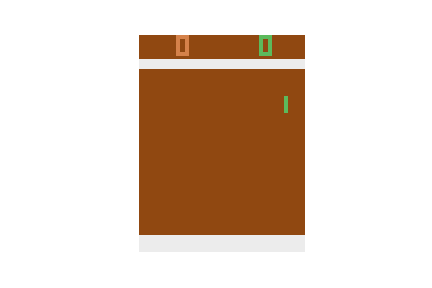
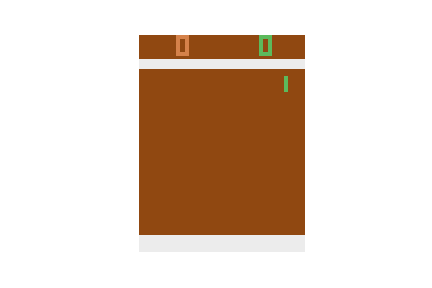
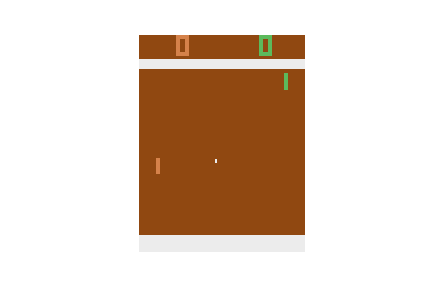
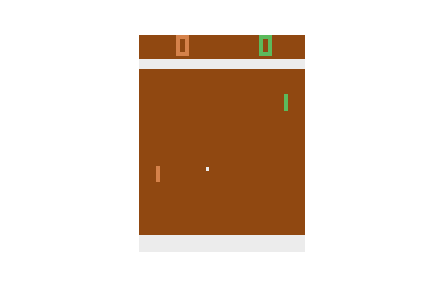
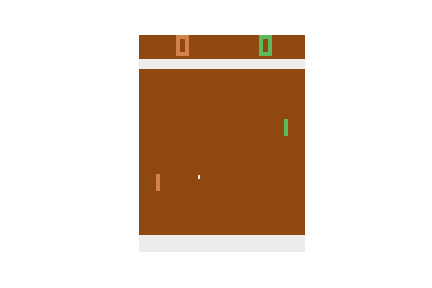
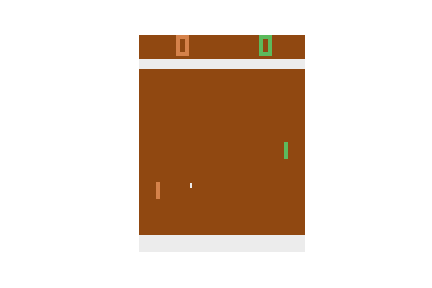
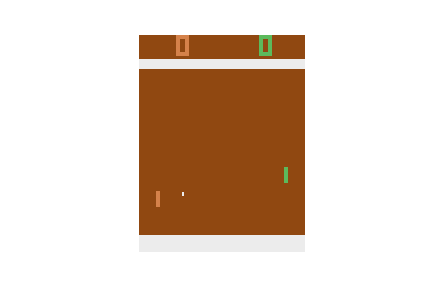
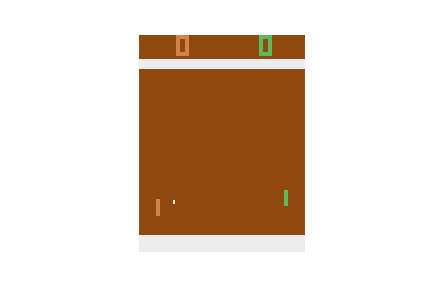
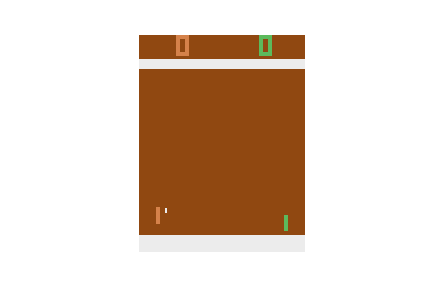
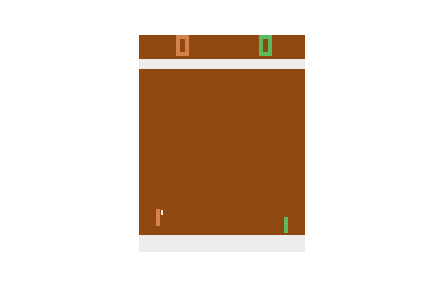
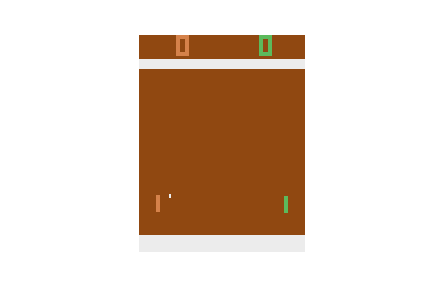
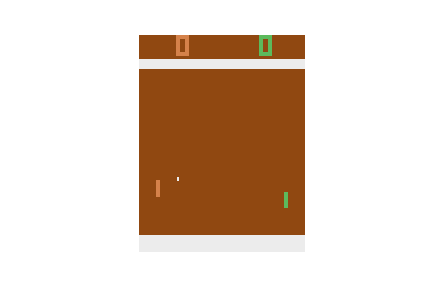
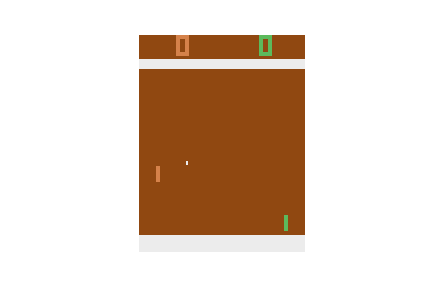
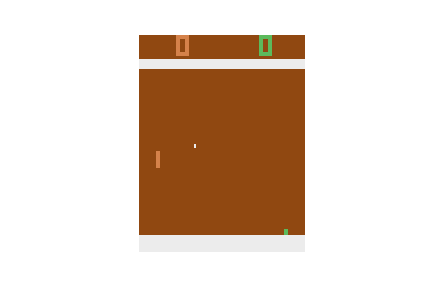
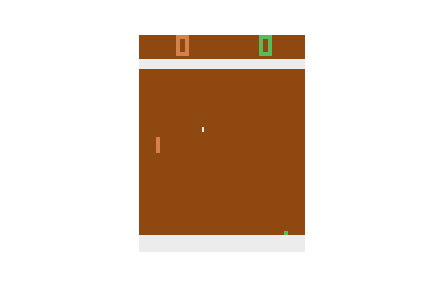
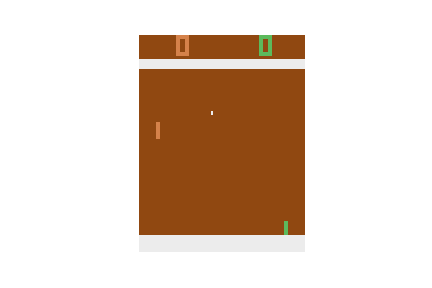
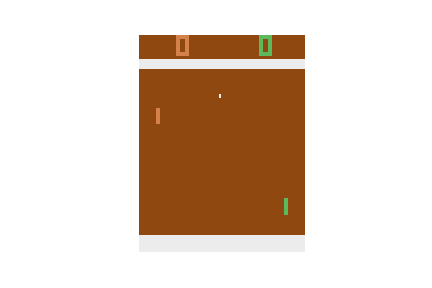
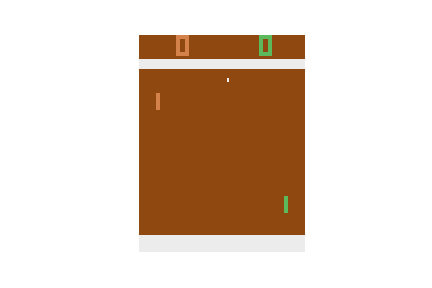
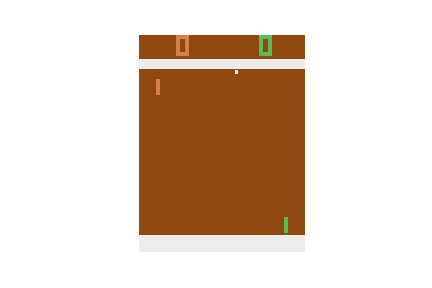
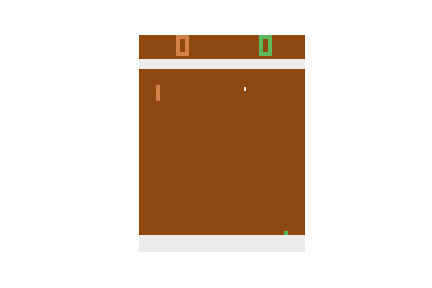
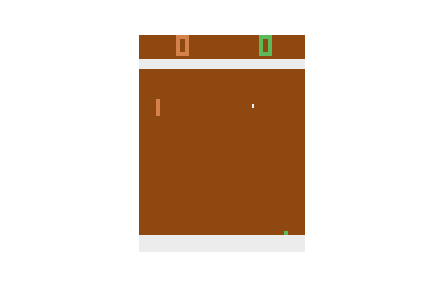
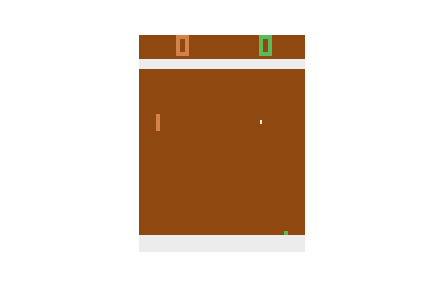
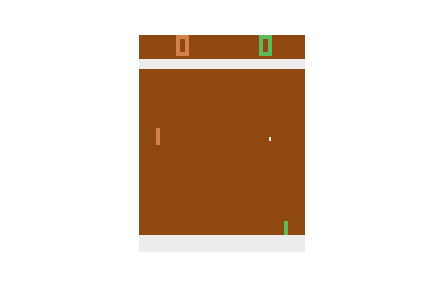
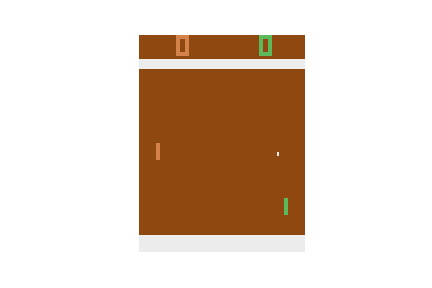
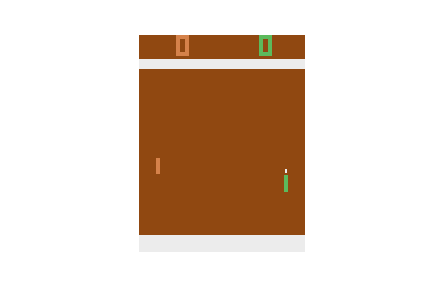
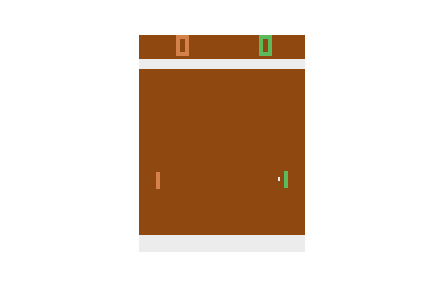
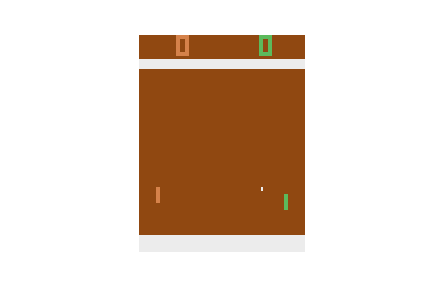
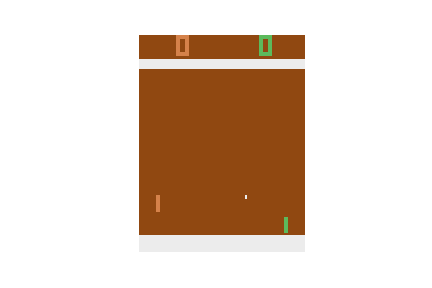
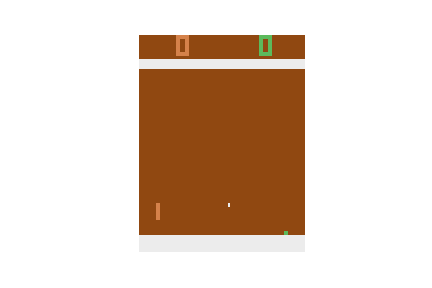
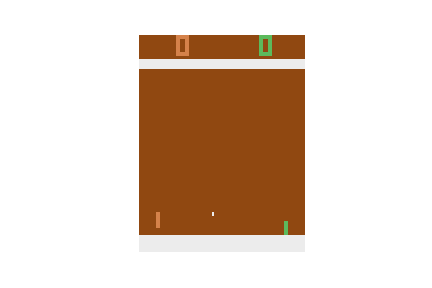
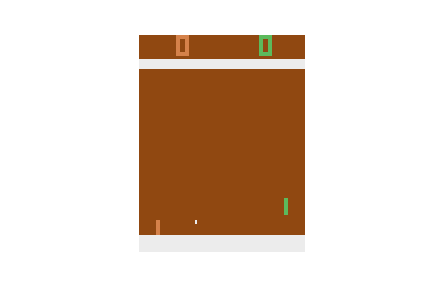
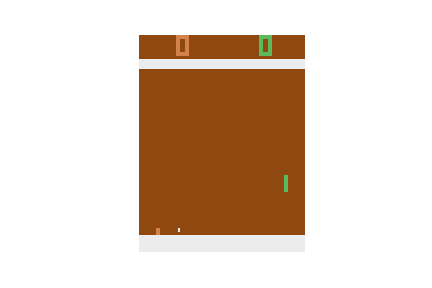
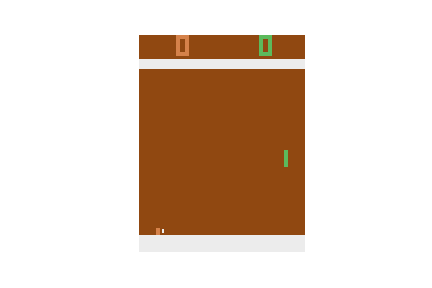
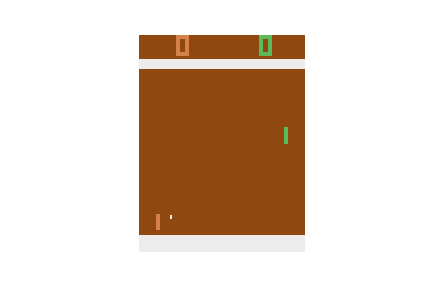
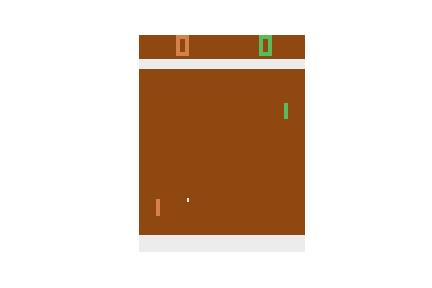
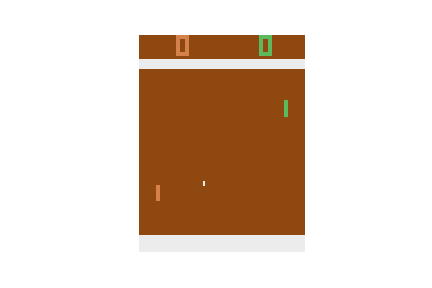
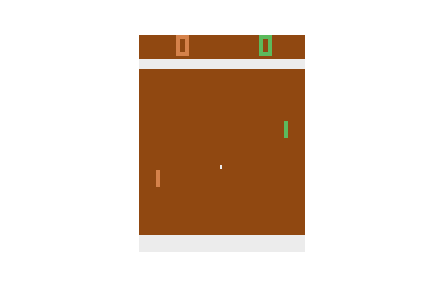
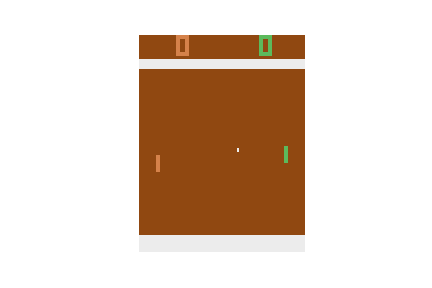
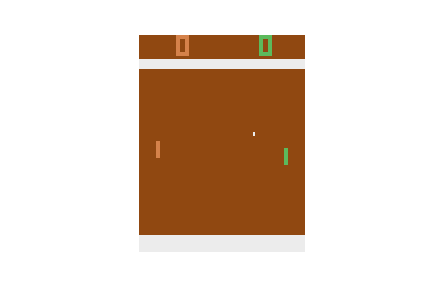
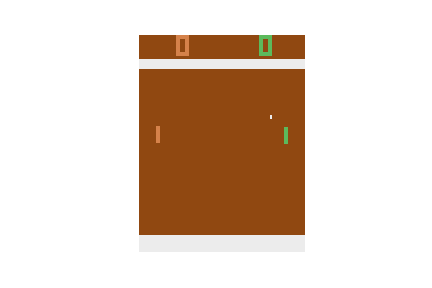
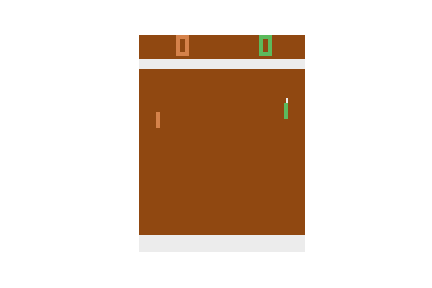
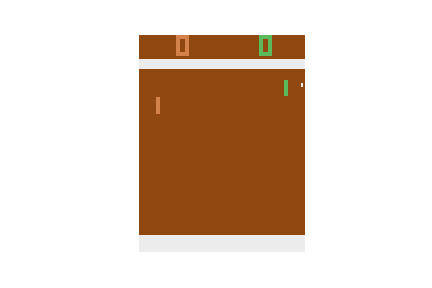
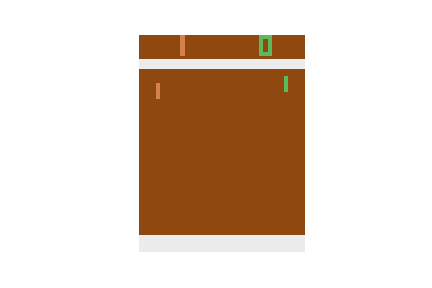
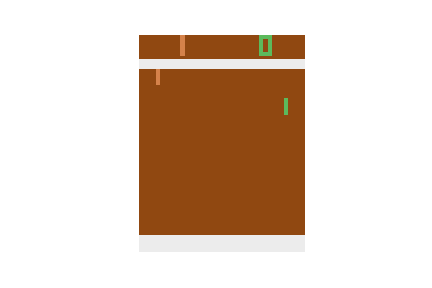
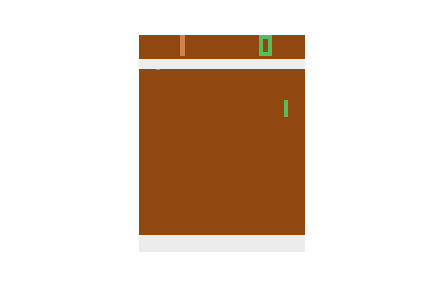
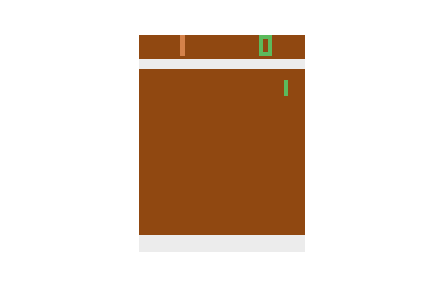
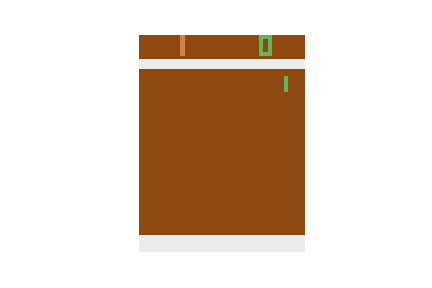
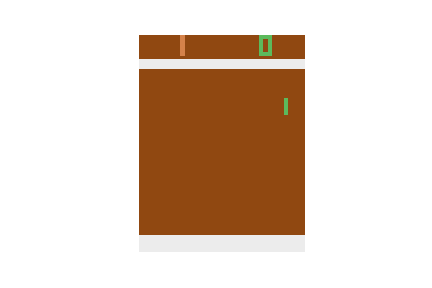
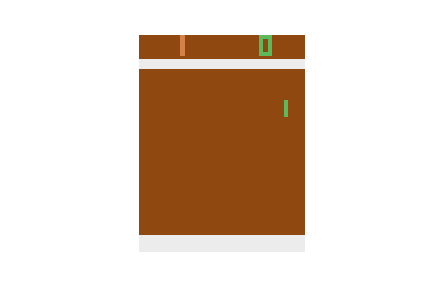
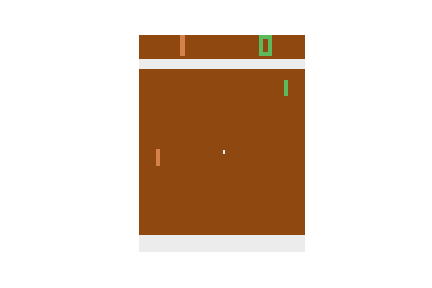
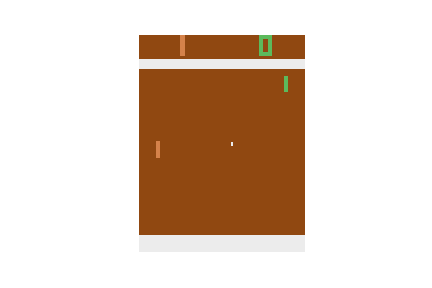
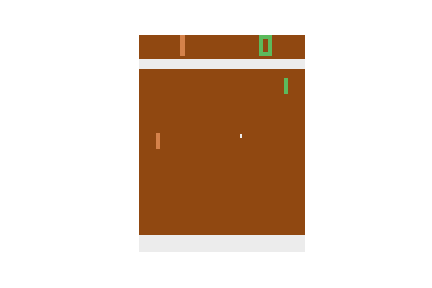
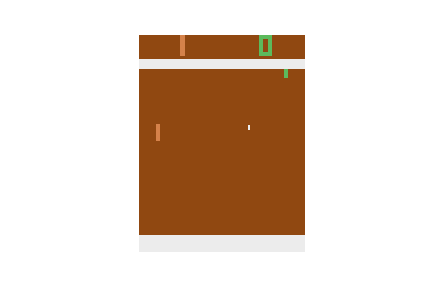
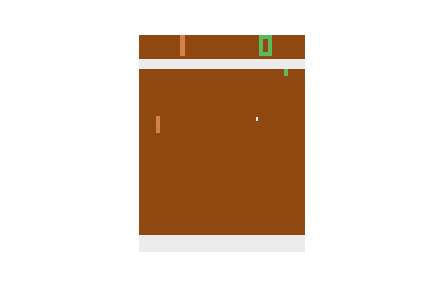
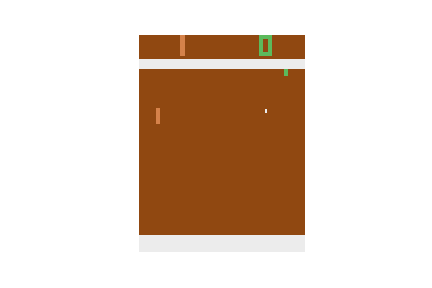
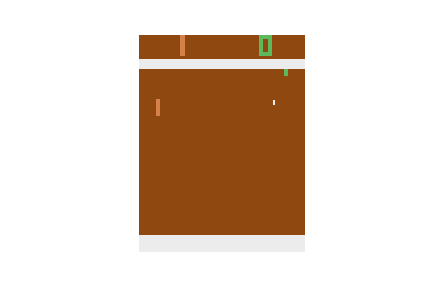
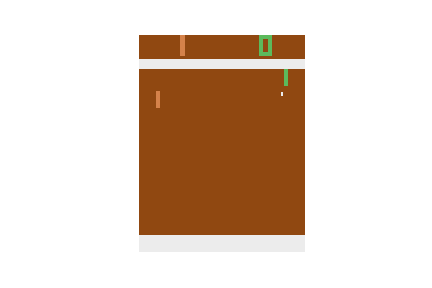
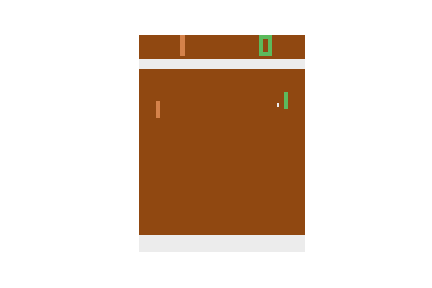
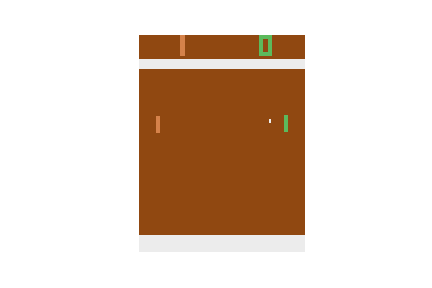
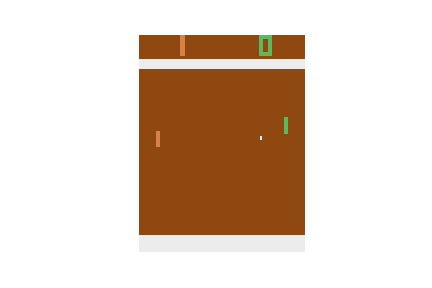
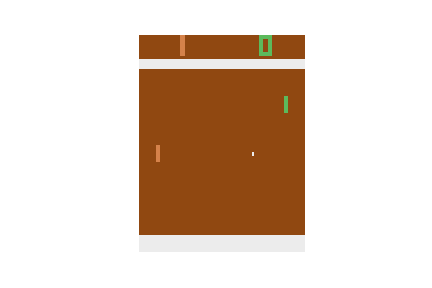
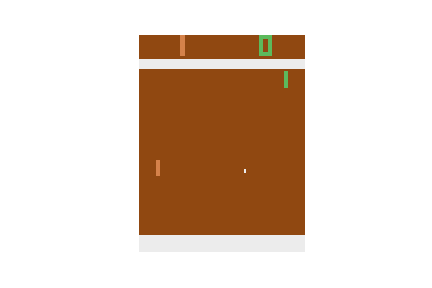
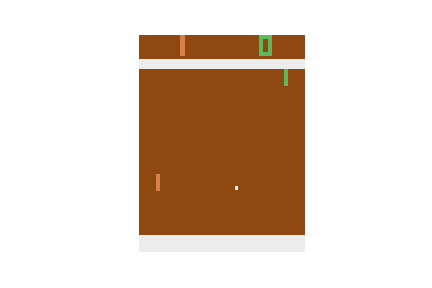
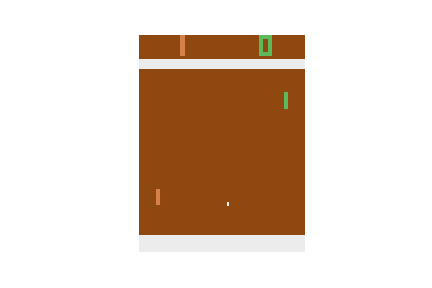
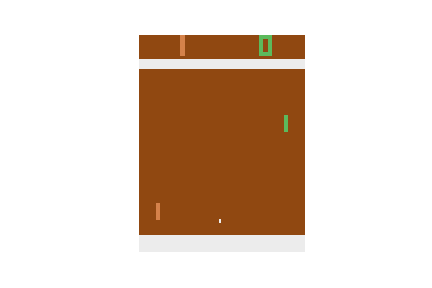
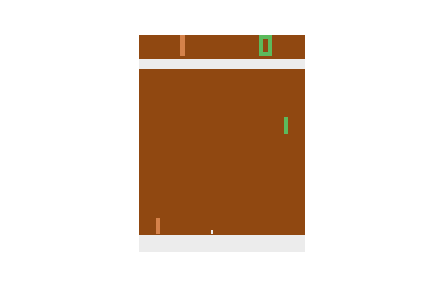
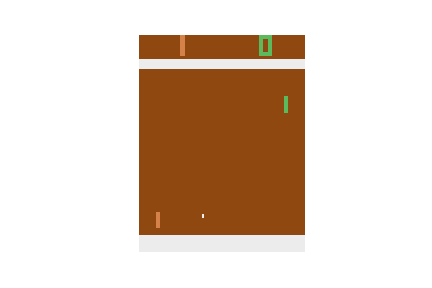
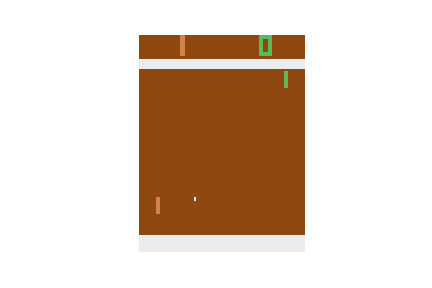
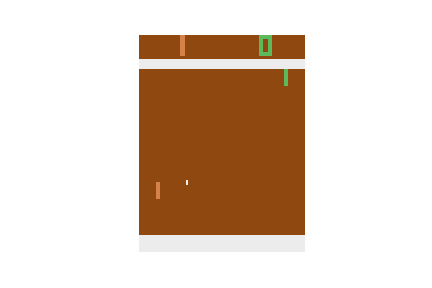
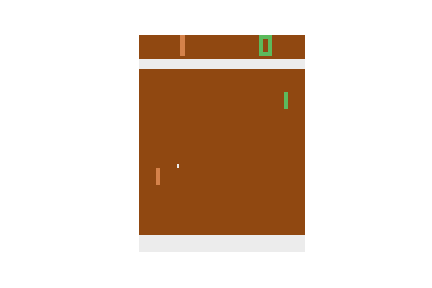
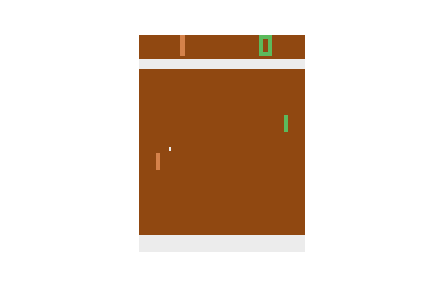
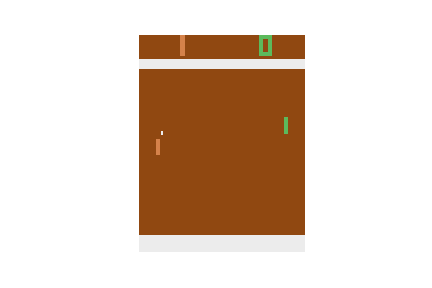
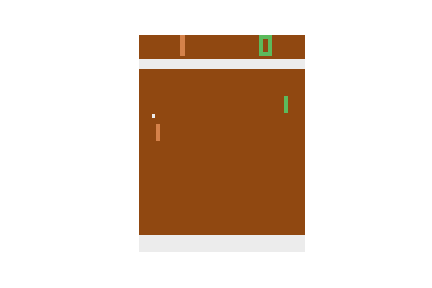
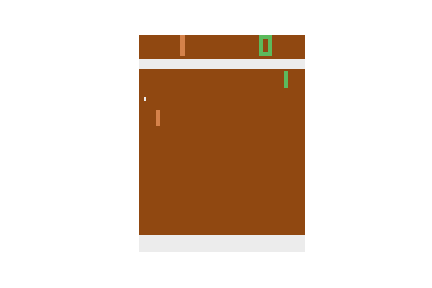
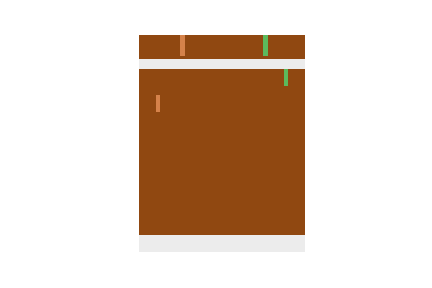
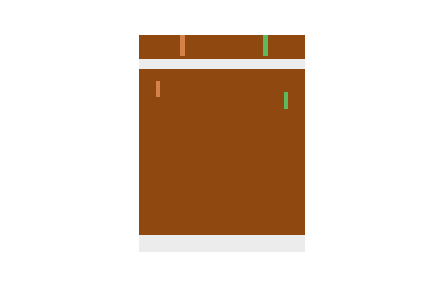
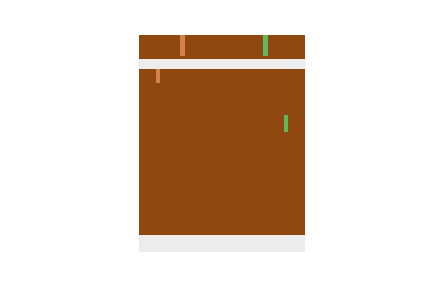
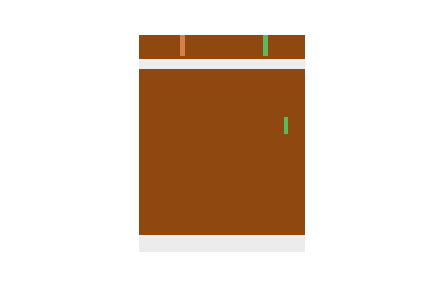
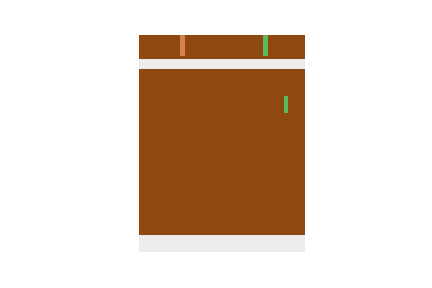
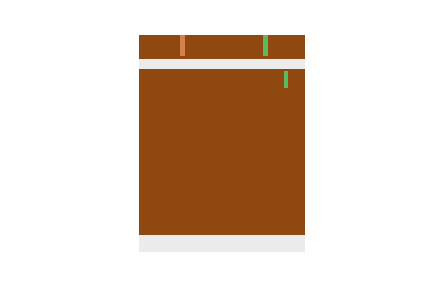
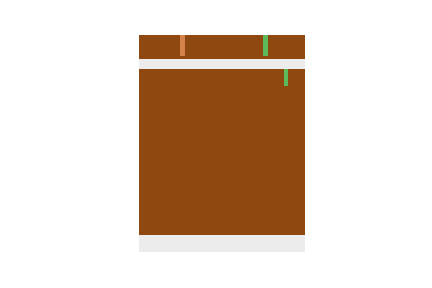
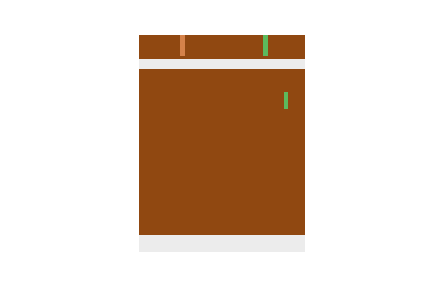
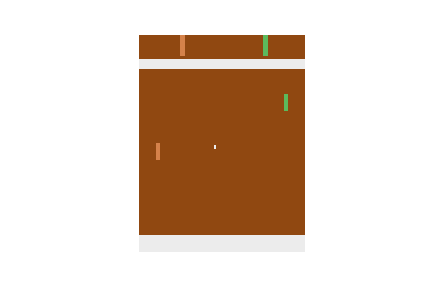
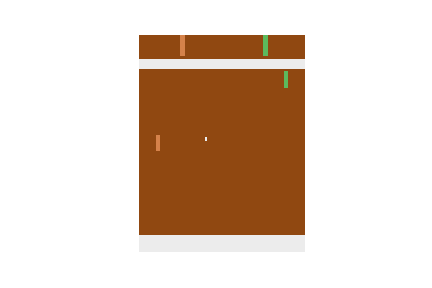
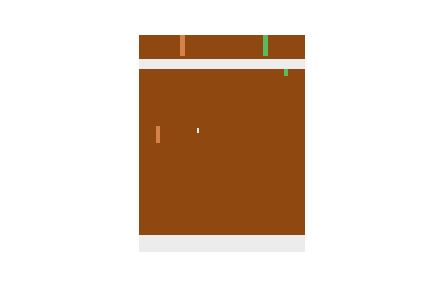
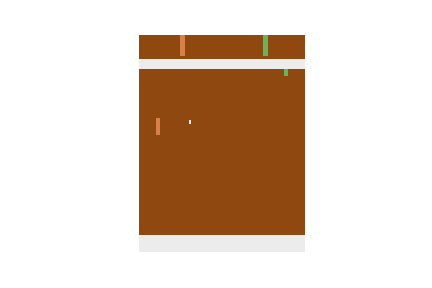
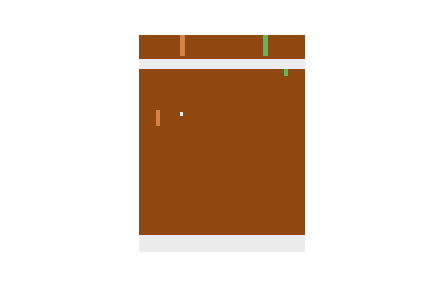
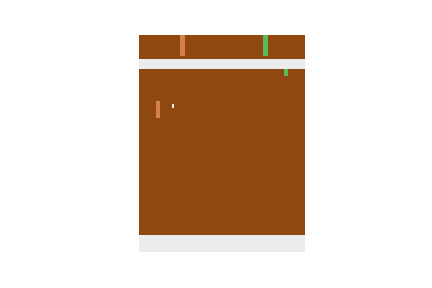
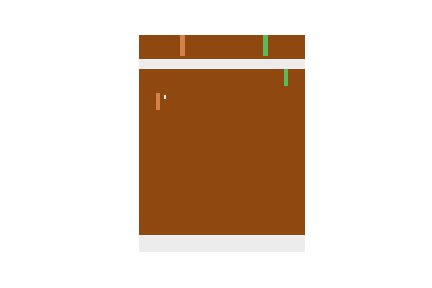
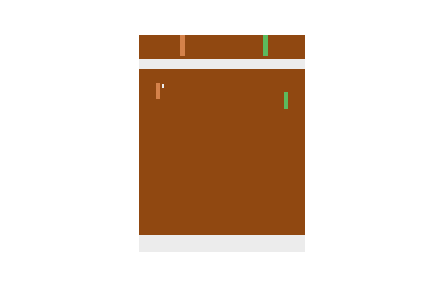
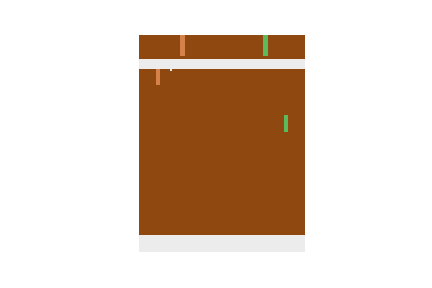
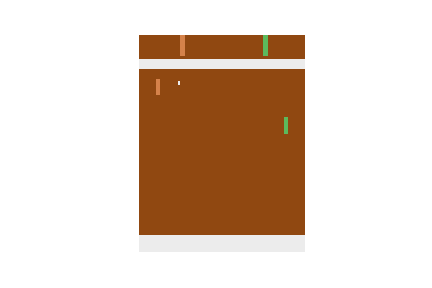
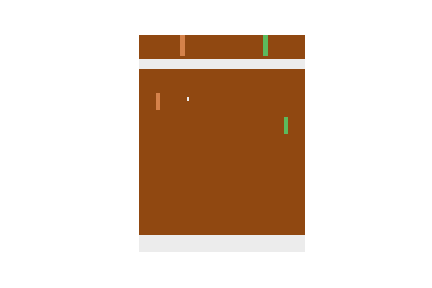
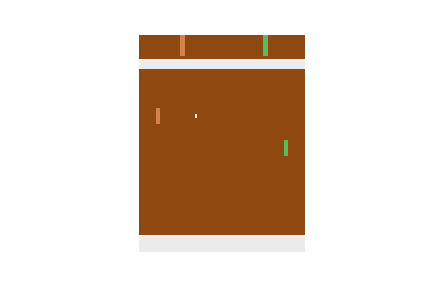
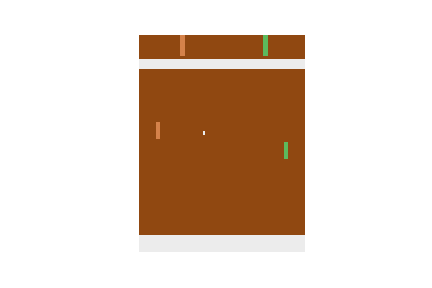
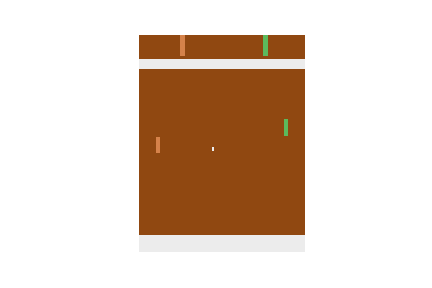
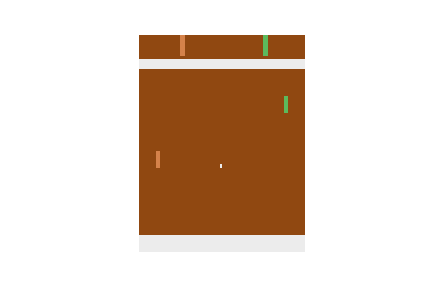
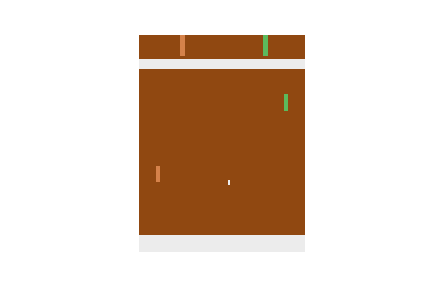
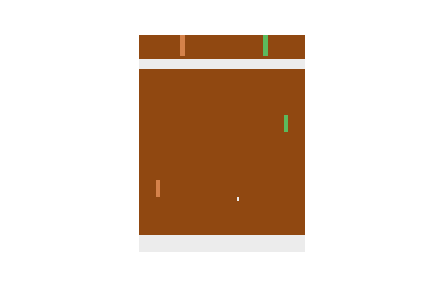
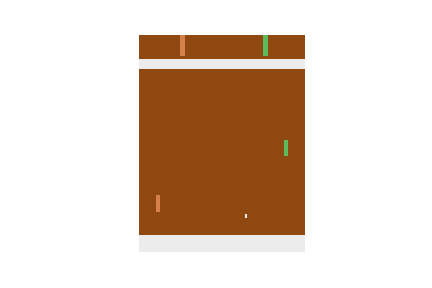
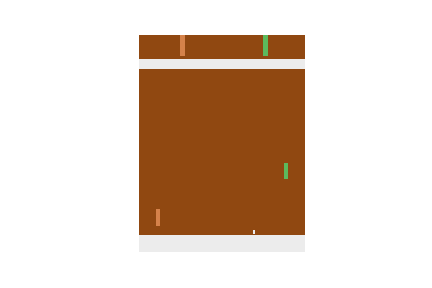
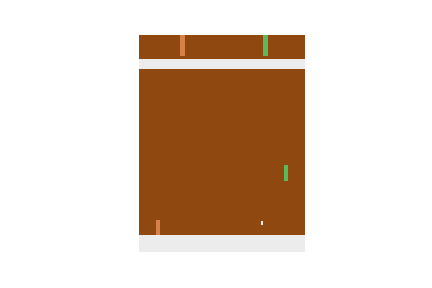
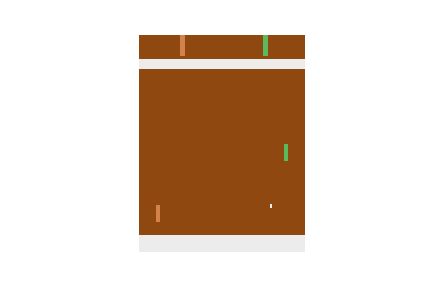
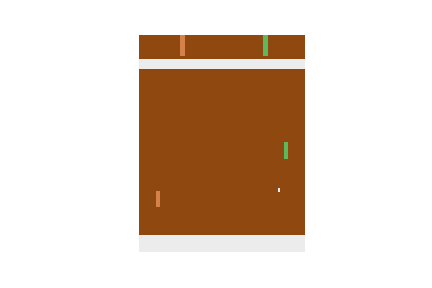
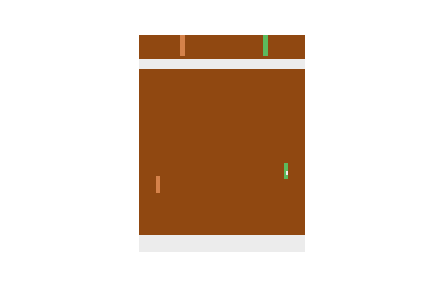
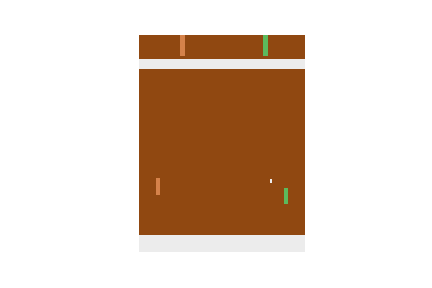
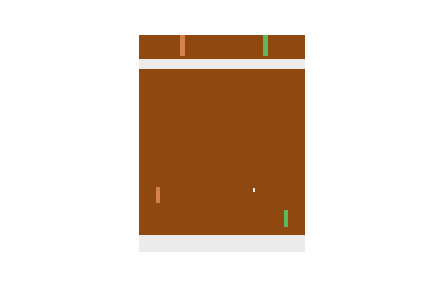
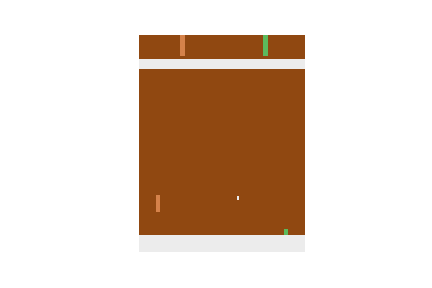
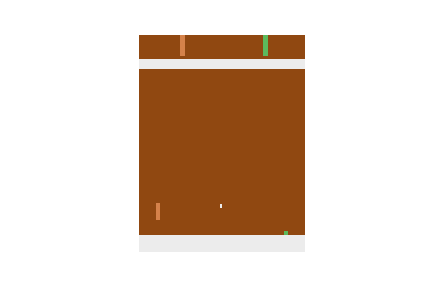
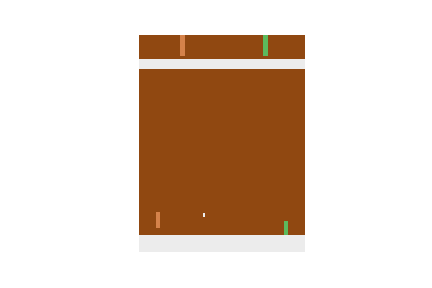
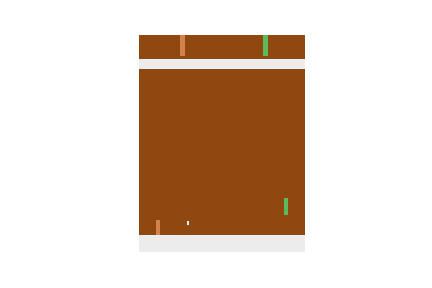
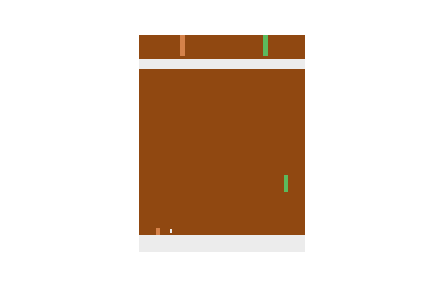
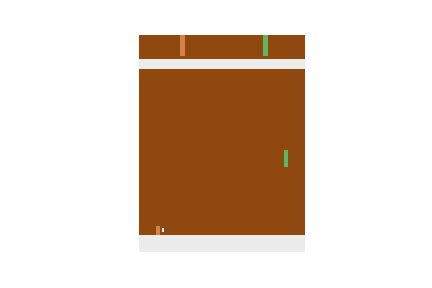
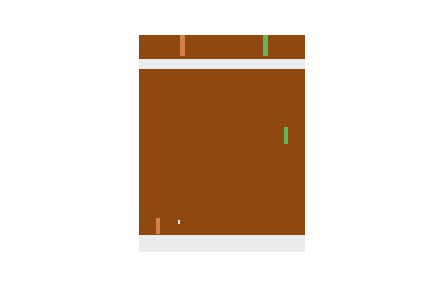
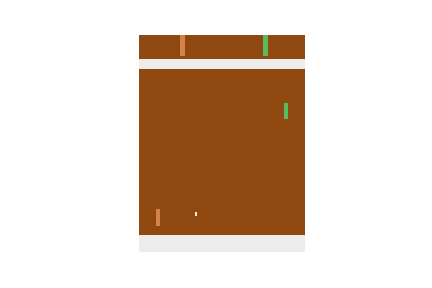
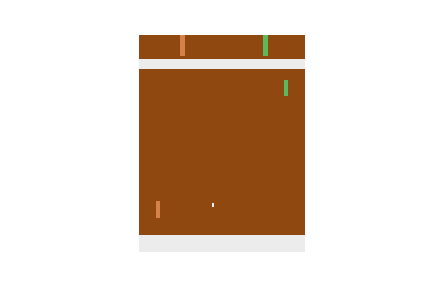
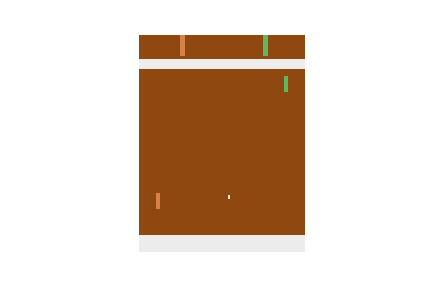
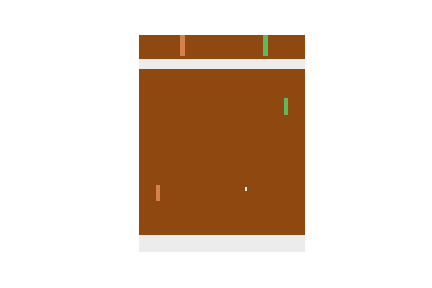
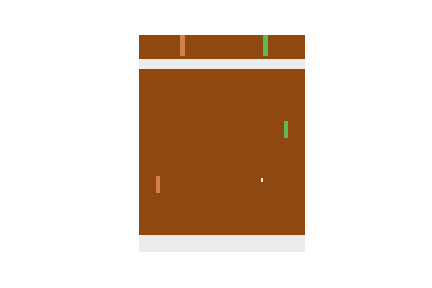
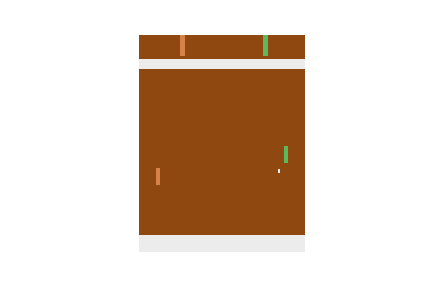
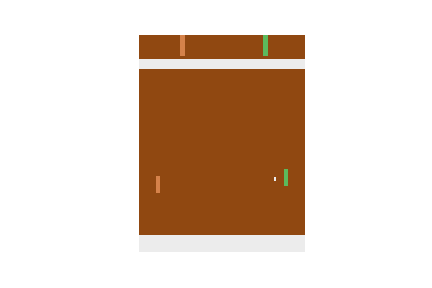
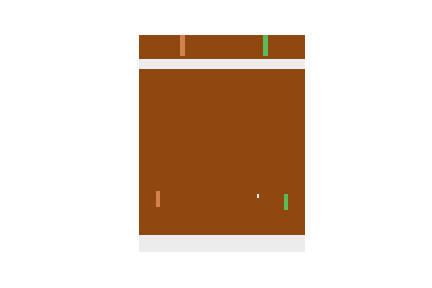
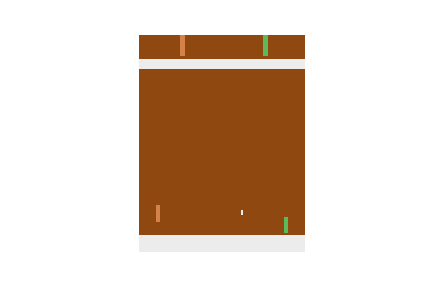
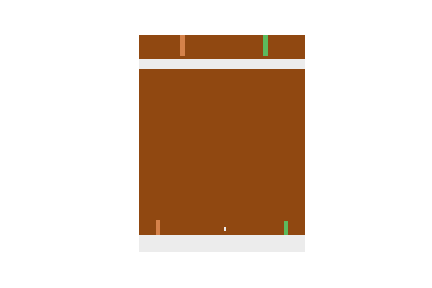
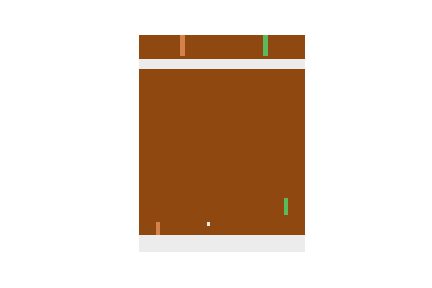
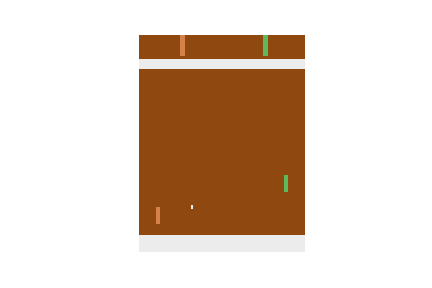
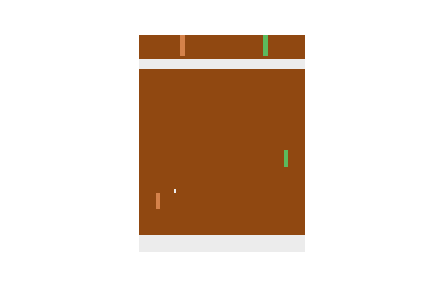
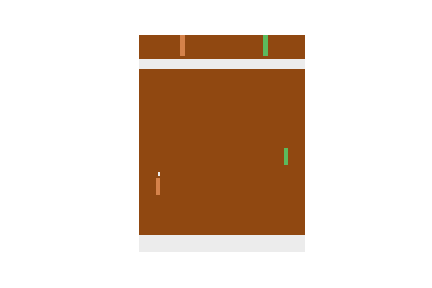
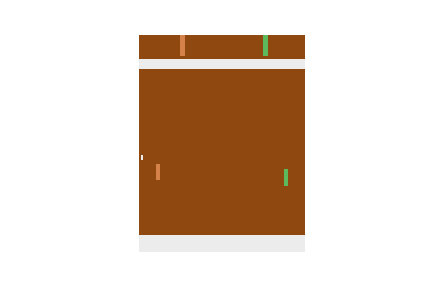
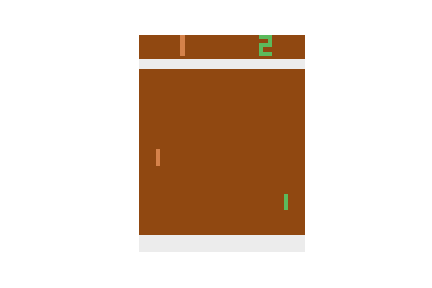
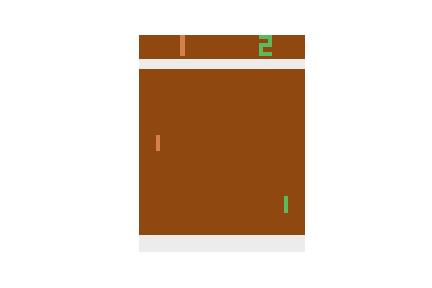
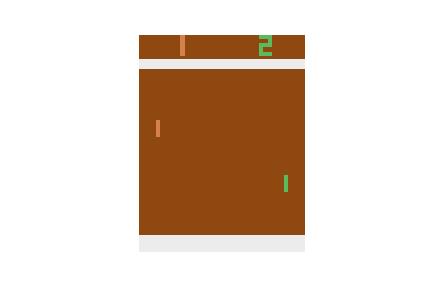
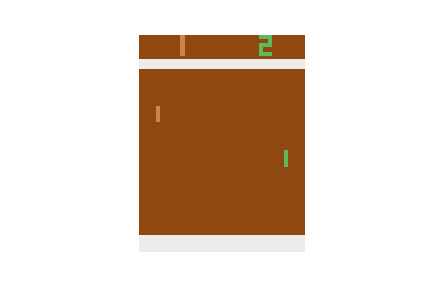
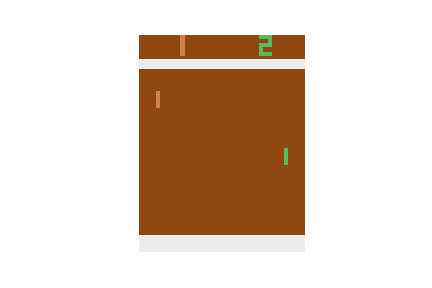
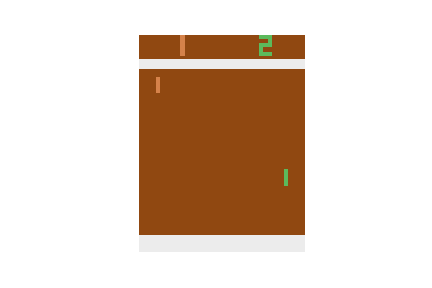
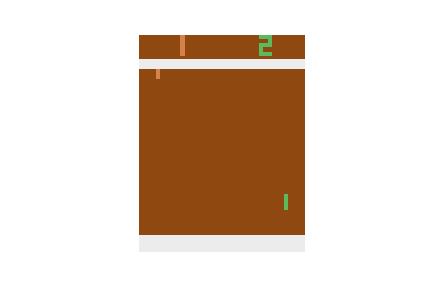
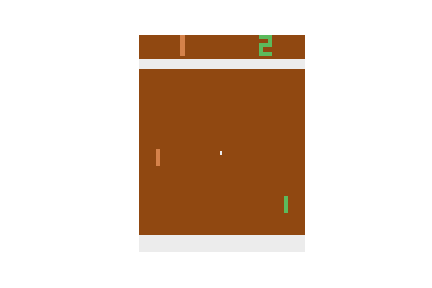
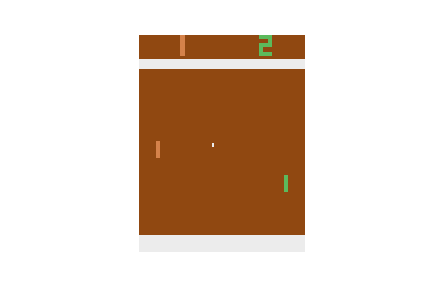
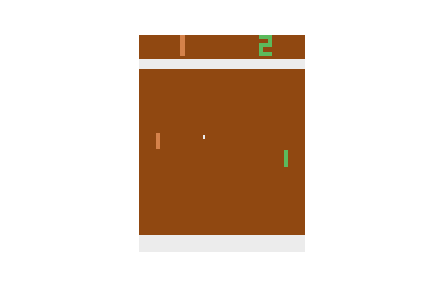
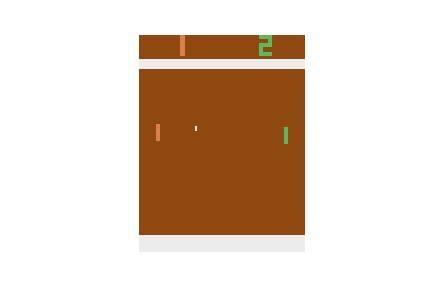
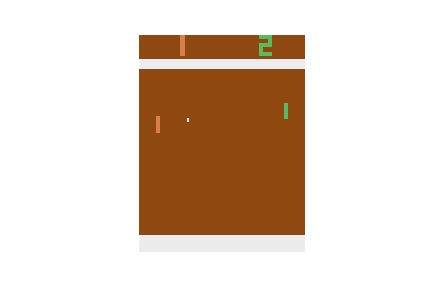
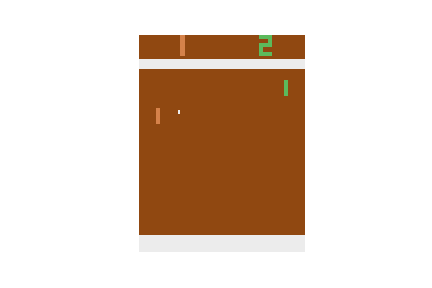
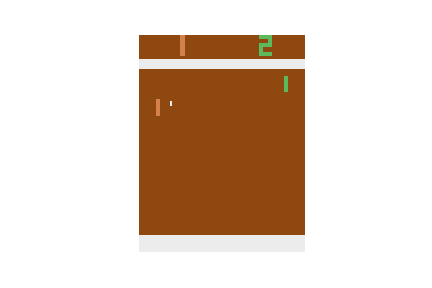
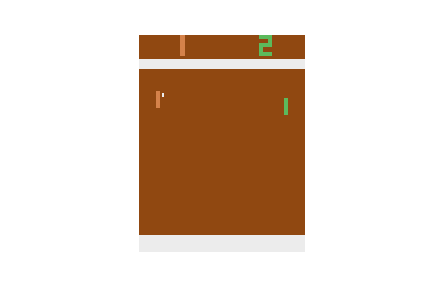
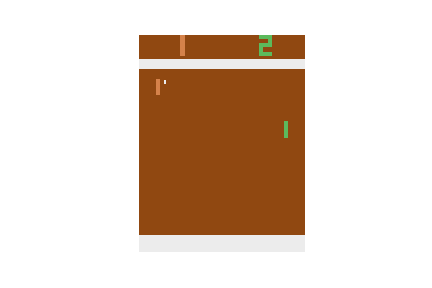
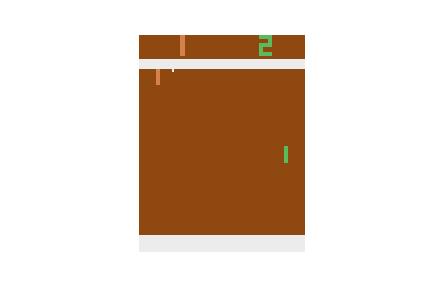
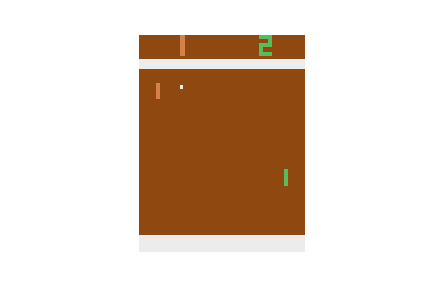
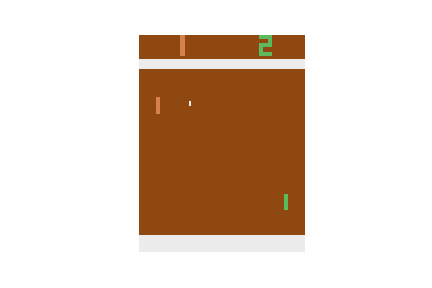
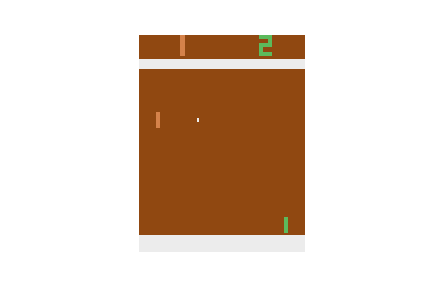
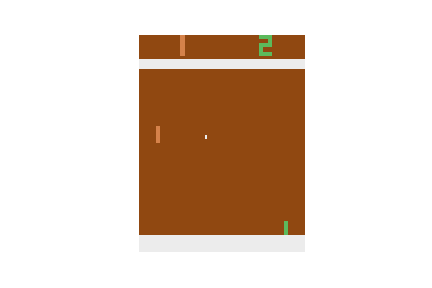
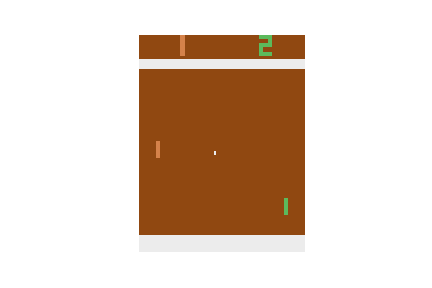
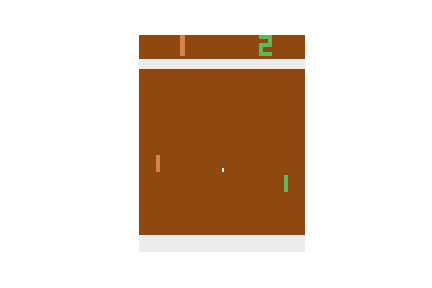
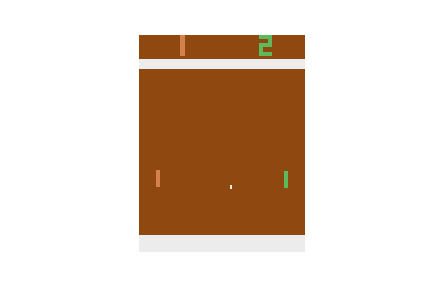
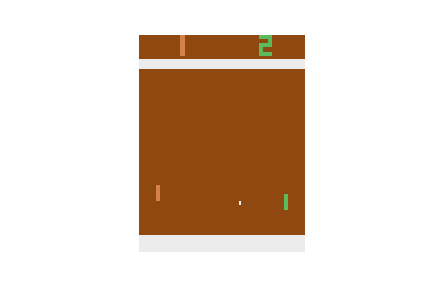
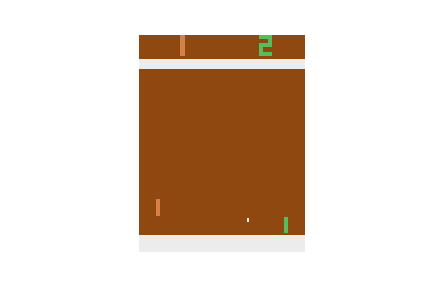
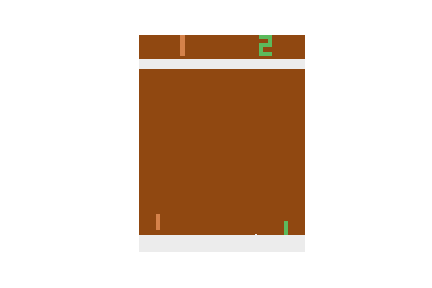
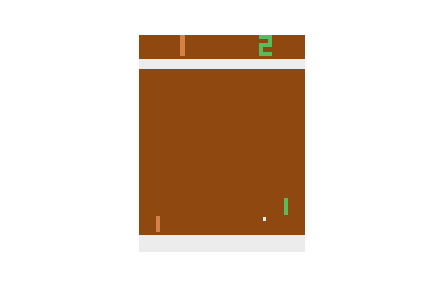
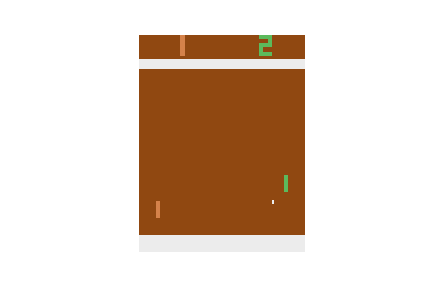
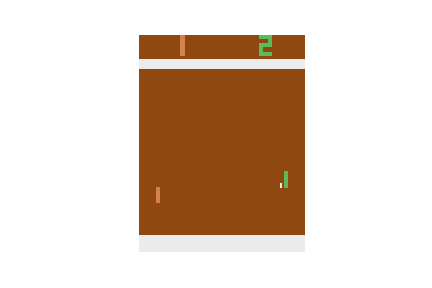
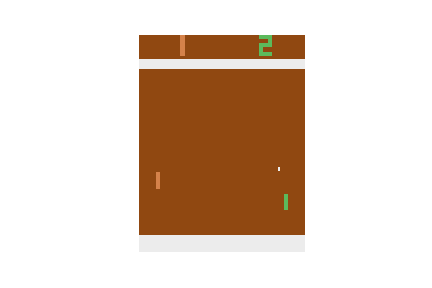
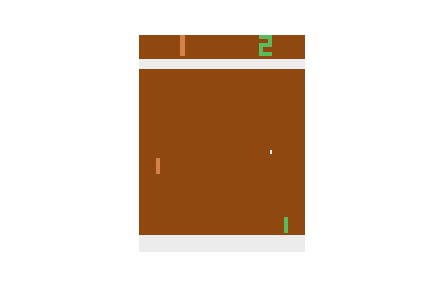
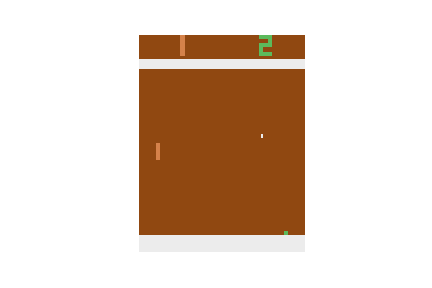
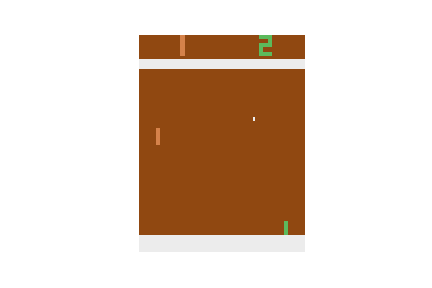
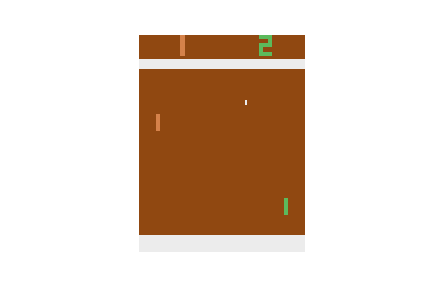
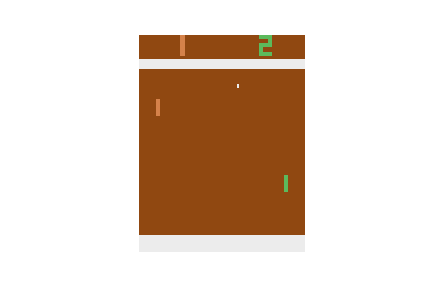
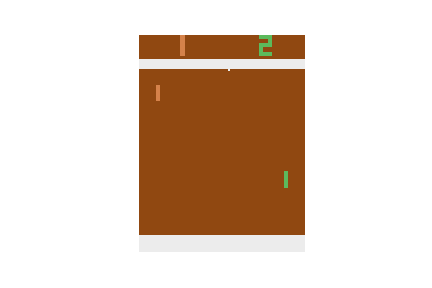
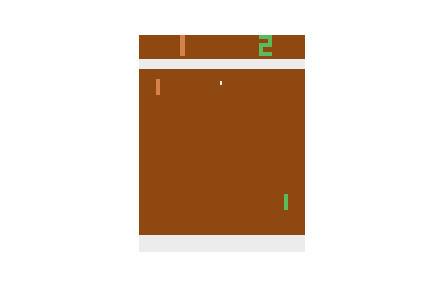
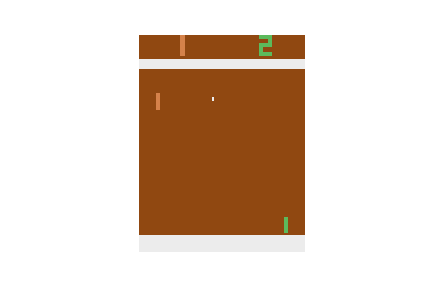
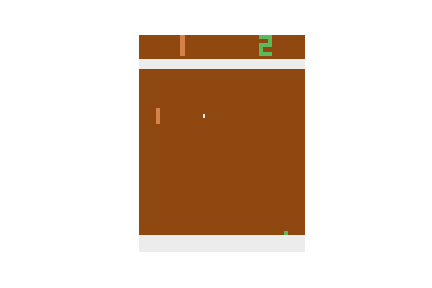
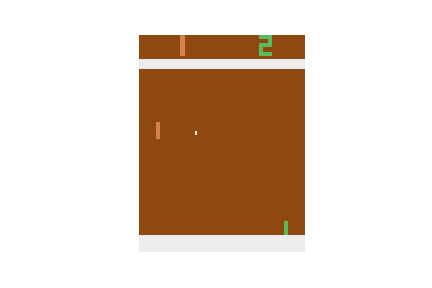
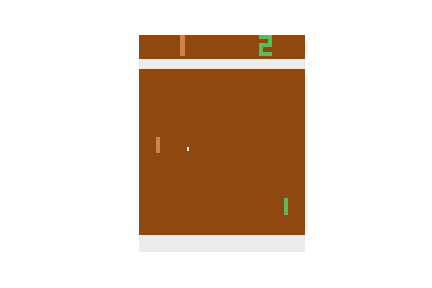
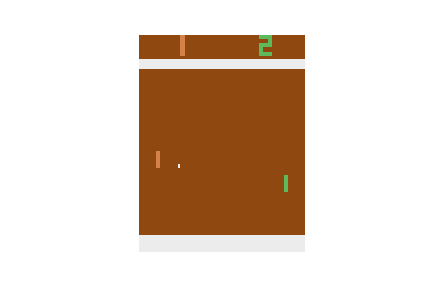
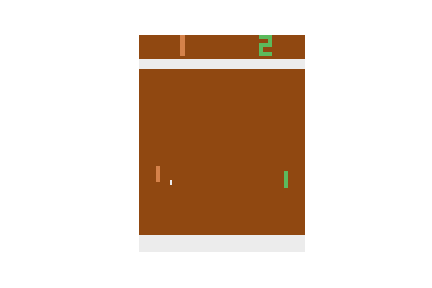
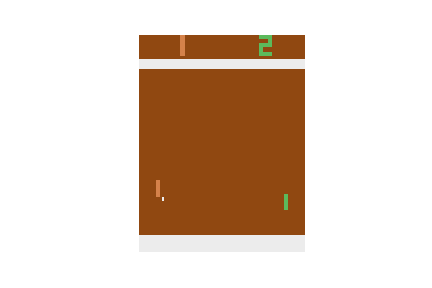
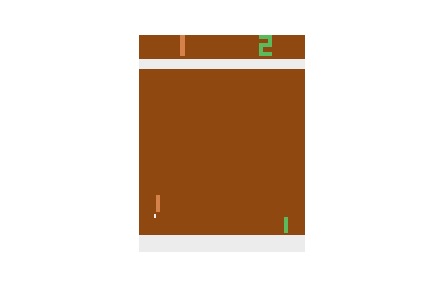
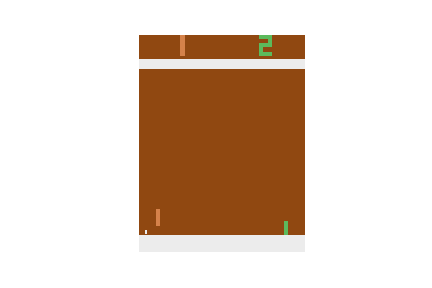
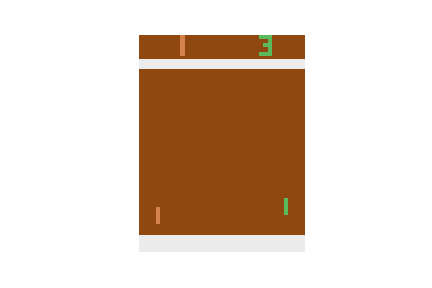
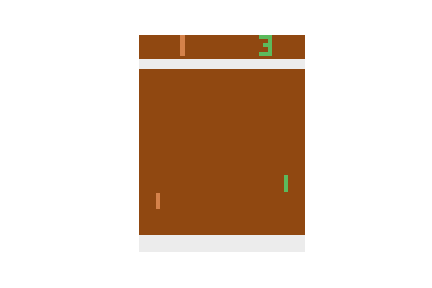
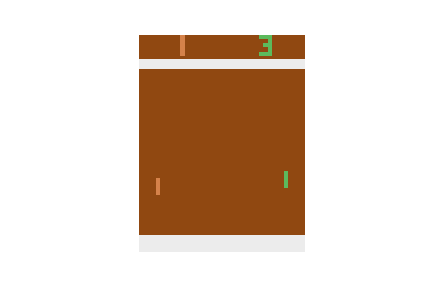
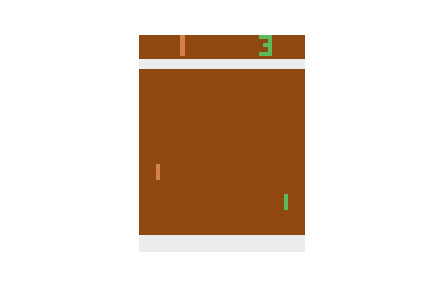
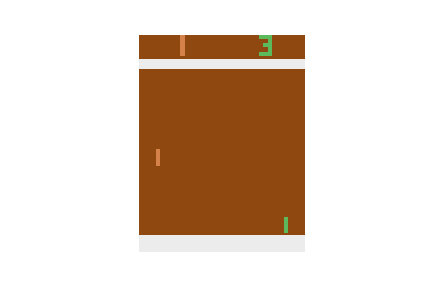
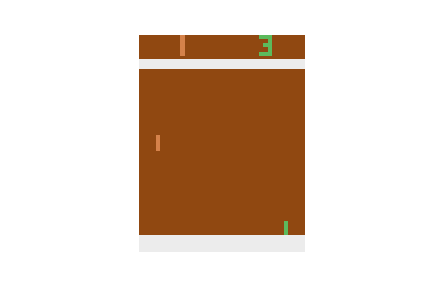
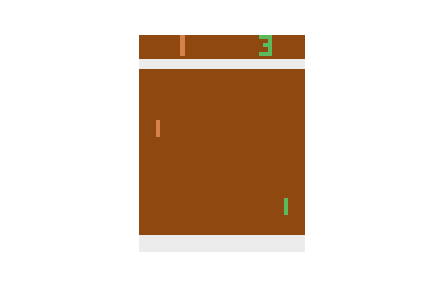
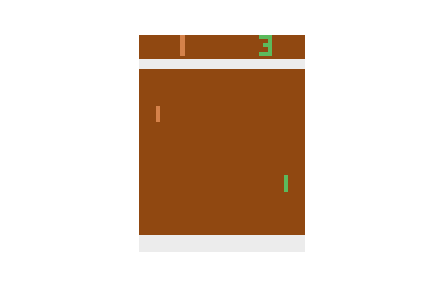
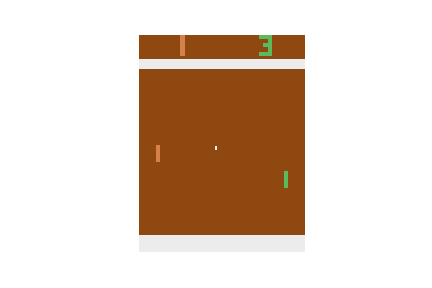
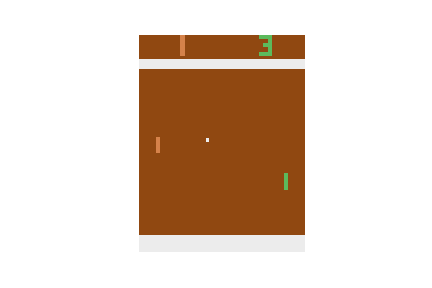
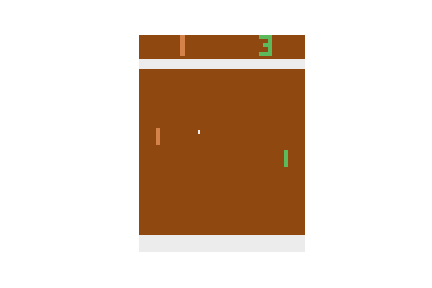
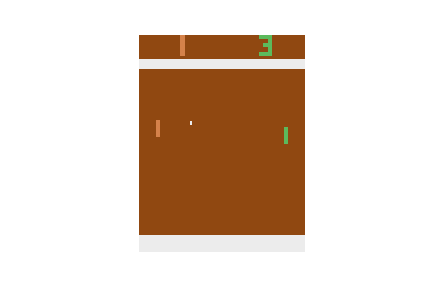
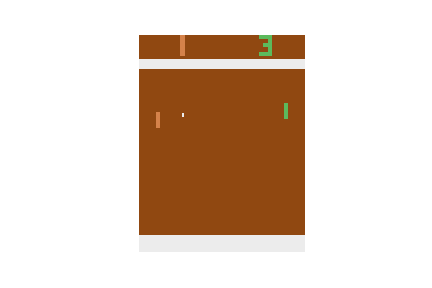
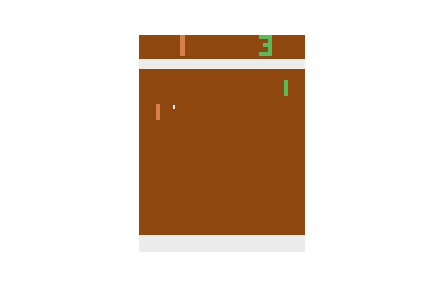
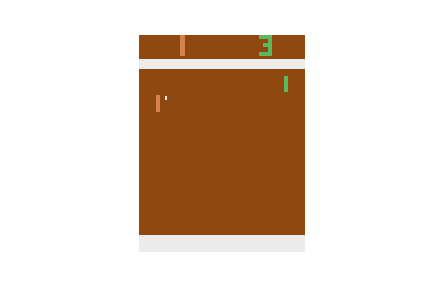
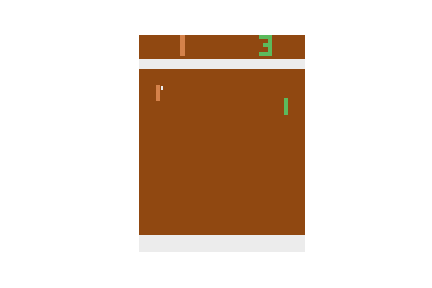
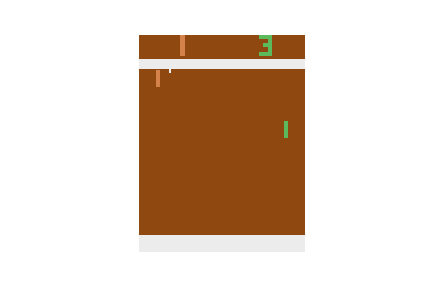
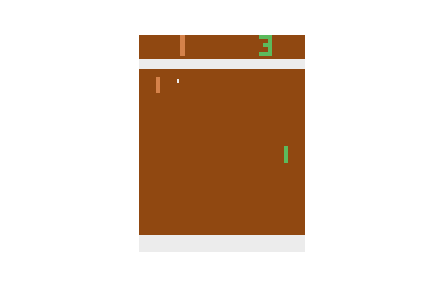
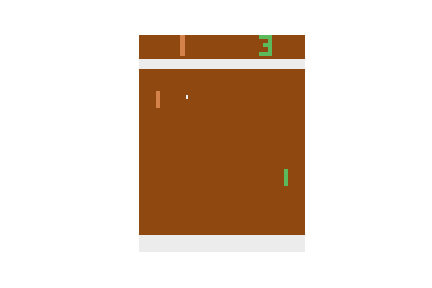
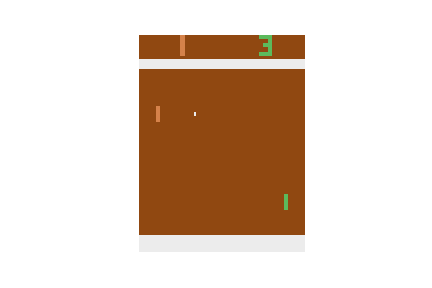
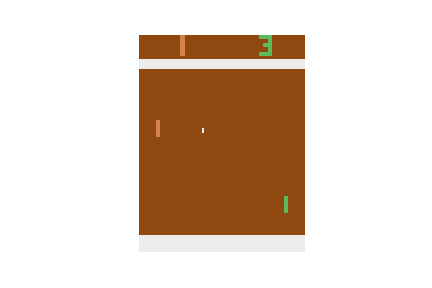
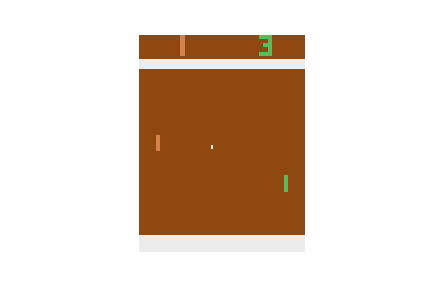
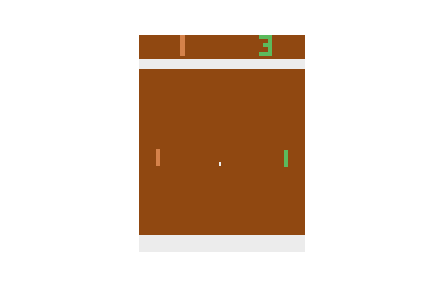
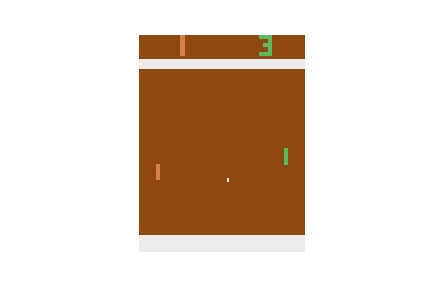

In [8]:
pong_utils.play(env, policy, time=200) 

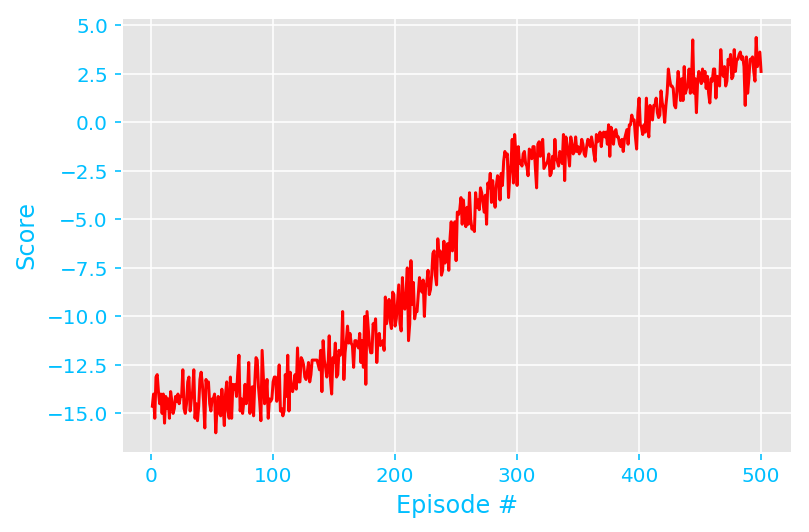

In [9]:
# Add-on : Enhanced Rewards plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='x', colors='deepskyblue')
ax.tick_params(axis='y', colors='deepskyblue')
plt.plot(np.arange(1, len(mean_rewards)+1), mean_rewards, color='red')
plt.ylabel('Score', color='deepskyblue')
plt.xlabel('Episode #', color='deepskyblue')
plt.show()

In [ ]:
# save your policy!
#torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 